In [1]:
# IMPORTING THE REQUIRED LIBRARIES OR LIBRARIES THAT MAY BE OF USE
import os
import pandas as pd
import numpy as np
import re
from datetime import datetime
import plotly.express as px
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, f1_score, silhouette_score, mean_absolute_error, mean_squared_error, r2_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from scipy.stats import f_oneway
import math
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import label_binarize
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.over_sampling import SMOTE, SMOTENC
import traceback
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedShuffleSplit
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import ks_2samp

import statsmodels.api as sm
import shap

import seaborn as sns
path = './'

# SETTING DISPLAY OPTIONS TO SHOW ALL ROWS AND COLUMNS IN DATAFRAMES
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# SETTING THE FLOAT DISPLAY OPTION TO TWO PLACES AFTER THE DECIMAL
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

2026-02-10 13:12:40.116390: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-10 13:12:40.120301: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-10 13:12:40.132296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770729160.157240  616386 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770729160.163232  616386 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770729160.178876  616386 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Map generated features for the model (dummy cols) back to their original columns
def map_to_orig(feat, feature_to_orig):
    """
    Map a processed feature name back to its original column name.

    Parameters
    ----------
    feat : str
        Processed feature name (e.g. dummy-encoded column).
    feature_to_orig : dict
        Dictionary mapping processed feature names to original column names.

    Returns
    -------
    str
        Original column name corresponding to the processed feature.
    """
    if feat in feature_to_orig:
        return feature_to_orig[feat]
    # fallback: split on first "_" (covers many get_dummies cases)
    if "_" in feat:
        return feat.split("_", 1)[0]
    return feat

# given the model name, data as inputs, this function returns the respective evaluation metrics for the model, along with all the datasets
# used during the model training process
def run_binary_model_pipeline(df,tar_col,mcols,test_size=0.2,random_state=42,cv_folds=5,scale=False,
                              xgb=False,dt=False,hgbm=False,rf=False,params=None,use_sample_wt_xgb=False):
    """
    Run an end-to-end binary classification modeling pipeline.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataset containing features and target variable.
    tar_col : str
        Name of the binary target column (0/1).
    mcols : list of str
        List of feature column names used for modeling.
    test_size : float, default=0.2
        Proportion of the dataset to include in the test split.
    random_state : int, default=42
        Random seed for reproducibility.
    cv_folds : int, default=5
        Number of stratified cross-validation folds.
    scale : bool, default=False
        Whether to standardize numeric features.
    xgb : bool, default=False
        If True, train an XGBoost classifier.
    dt : bool, default=False
        If True, train a Decision Tree classifier.
    hgbm : bool, default=False
        If True, train a HistGradientBoosting classifier.
    rf : bool, default=False
        If True, train a Random Forest classifier.
    params : dict or None
        Model-specific hyperparameters.
    use_sample_wt_xgb : bool, default=False
        Whether to apply class-balanced sample weights (XGBoost only).

    Returns
    -------
    dict
        Dictionary containing model outputs and evaluation artifacts:

        - cv_scores : ndarray
            ROC-AUC scores from cross-validation.
        - cv_summary : pandas.DataFrame
            Mean and standard deviation of CV ROC-AUC.
        - train_metrics : pandas.DataFrame
            Performance metrics on training data.
        - test_metrics : pandas.DataFrame
            Performance metrics on test data.
        - confusion_matrix_train : ndarray
            Confusion matrix for training data.
        - confusion_matrix_test : ndarray
            Confusion matrix for test data.
        - classification_report_train : pandas.DataFrame
            Classification report for training data.
        - classification_report_test : pandas.DataFrame
            Classification report for test data.
        - feature_importance : pandas.DataFrame
            Feature importance at processed-feature level.
        - feature_importance_agg : pandas.DataFrame
            Feature importance aggregated to original columns.
        - model : object
            Fitted model instance.
        - y_train : pandas.Series
            Target values for training data.
        - y_test : pandas.Series
            Target values for test data.
        - X_train_processed : pandas.DataFrame
            Processed training feature matrix.
        - X_test_processed : pandas.DataFrame
            Processed test feature matrix.
        - y_train_proba : ndarray
            Predicted probabilities for training data.
        - y_test_proba : ndarray
            Predicted probabilities for test data.
    """
    # Split features
    num_features = df[mcols].select_dtypes(include=['float','int']).columns.tolist()
    cat_features = df[mcols].select_dtypes(exclude=['float','int']).columns.tolist()

    X = df[mcols].fillna(0)
    y = df[[tar_col]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Reduce high-cardinality cats
    train_all = X_train.join(y_train)
    for c in cat_features:
        if X_train[c].nunique() > 5:
            top_cats = list(train_all[c].value_counts(dropna=False).keys()[:5])
            X_train[c] = X_train[c].apply(lambda x: x if x in top_cats else 'Others')
            X_test[c] = X_test[c].apply(lambda x: x if x in top_cats else 'Others')

    large_cardinality_cats = [c for c in cat_features if X[c].nunique() > 5]
    small_cardinality_cats = [c for c in cat_features if c not in large_cardinality_cats]

    # Numeric features
    if scale:
        scaler = StandardScaler()
        X_train_num = pd.DataFrame(
            scaler.fit_transform(X_train[num_features]),
            columns=num_features, index=X_train.index
        )
        X_test_num = pd.DataFrame(
            scaler.transform(X_test[num_features]),
            columns=num_features, index=X_test.index
        )
    else:
        X_train_num = X_train[num_features].copy()
        X_test_num = X_test[num_features].copy()
        
    feature_to_orig = {} # map processed feature name -> original column

    # Dummies for large cats
    if large_cardinality_cats:
        train_dummies = pd.get_dummies(X_train[large_cardinality_cats].astype(str), drop_first=True)
        test_dummies = pd.get_dummies(X_test[large_cardinality_cats].astype(str), drop_first=True)
        test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)

        for col in large_cardinality_cats:
            for feat in train_dummies.columns:
                if feat.startswith(col + "_"):
                    feature_to_orig[feat] = col
    else:
        train_dummies = pd.DataFrame(index=X_train.index)
        test_dummies = pd.DataFrame(index=X_test.index)

    # Ordinal encoding small cats
    if small_cardinality_cats:
        ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        ord_enc.fit(X_train[small_cardinality_cats].astype(str))

        train_ord = pd.DataFrame(
            ord_enc.transform(X_train[small_cardinality_cats].astype(str)),
            columns=small_cardinality_cats, index=X_train.index
        )
        test_ord = pd.DataFrame(
            ord_enc.transform(X_test[small_cardinality_cats].astype(str)),
            columns=small_cardinality_cats, index=X_test.index
        )

        for c in small_cardinality_cats:
            feature_to_orig[c] = c
    else:
        train_ord = pd.DataFrame(index=X_train.index)
        test_ord = pd.DataFrame(index=X_test.index)

    for f in num_features:
        feature_to_orig[f] = f

    # Final matrices
    X_train_processed = pd.concat([X_train_num, train_dummies, train_ord], axis=1).fillna(0)
    X_test_processed = pd.concat([X_test_num, test_dummies, test_ord], axis=1).fillna(0)
    X_test_processed = X_test_processed.reindex(columns=X_train_processed.columns, fill_value=0)

    # Model selection
    if xgb:
        print ('Model used : XGB')
        model = XGBClassifier(**params)
    elif rf:
        print ('Model used : RF')
        model = RandomForestClassifier(**params)
    elif dt:
        print ('Model used : DT')
        model = DecisionTreeClassifier(**params)
    elif hgbm:
        print ('Model used : HGBGM')
        model = HistGradientBoostingClassifier(**params)
    else:
        print ('Model used : LG')
        # model = LogisticRegression(**params)
        model = LogisticRegression()
        
    if use_sample_wt_xgb:
        sample_weight = compute_sample_weight(
            class_weight="balanced",
            y=y_train
        )

        sample_weight[y_train == 2] *= 2.5
    else:
        sample_weight=None

    # Cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    cv_scores = cross_val_score(
        model,
        X_train_processed,
        y_train,
        scoring="roc_auc",
        cv=cv,
        fit_params={"sample_weight": sample_weight} if (xgb and use_sample_wt_xgb) else None,
        n_jobs=-1
    )

    cv_summary = pd.DataFrame({
        "roc_auc": cv_scores
    }).agg(['mean', 'std'])

    # Final fit
    features = X_train_processed.columns.tolist()
    if use_sample_wt_xgb:
        model.fit(X_train_processed, y_train, sample_weight=sample_weight)
    else:
        model.fit(X_train_processed, y_train)

    # Train evaluation
    y_train_pred = model.predict(X_train_processed)
    y_train_proba = model.predict_proba(X_train_processed)[:, 1]

    train_metrics = pd.DataFrame([{
        "accuracy": accuracy_score(y_train, y_train_pred),
        "precision": precision_score(y_train, y_train_pred, zero_division=0),
        "recall": recall_score(y_train, y_train_pred, zero_division=0),
        "f1": f1_score(y_train, y_train_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_train, y_train_proba)
    }])

    # Test evaluation
    y_test_pred = model.predict(X_test_processed)
    y_test_proba = model.predict_proba(X_test_processed)[:, 1]

    test_metrics = pd.DataFrame([{
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, zero_division=0),
        "recall": recall_score(y_test, y_test_pred, zero_division=0),
        "f1": f1_score(y_test, y_test_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_test_proba)
    }])

    # ROC plot
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc_val = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.3f}")
    plt.plot([0,1],[0,1],"--", linewidth=0.8)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Test set")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Feature importance
    feat_df = agg_df = None

    if not xgb and not dt and not rf and not hgbm:
        coefs = model.coef_[0]
        feat_df = pd.DataFrame({
            "feature": X_train_processed.columns,
            "coef": coefs,
            "abs_coef": np.abs(coefs)
        })
        feat_df["orig_col"] = feat_df["feature"].map(
            lambda x: feature_to_orig.get(x, x.split("_",1)[0])
        )
        feat_df.sort_values('coef',ascending=False,inplace=True)
        feat_df.reset_index(drop=True,inplace=True)

        agg_df = feat_df.groupby("orig_col").agg(
            sum_abs=("abs_coef","sum"),
            mean_abs=("abs_coef","mean"),
            n_levels=("feature","count")
        ).sort_values("sum_abs", ascending=False)
    elif hgbm:
        perm = permutation_importance(
            model,
            X_test_processed,        # or X_val
            y_test,
            scoring="roc_auc",
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )

        feat_df = pd.DataFrame({
            "feature": X_test_processed.columns,
            "importance_mean": perm.importances_mean,
            "importance_std": perm.importances_std
        }).sort_values("importance_mean", ascending=False)
    else:
        feat_df = pd.DataFrame({
            "feature": X_train_processed.columns,
            "gain": model.feature_importances_
        })
        feat_df["orig_col"] = feat_df.apply(lambda x : map_to_orig(x["feature"], feature_to_orig), axis=1)
        feat_df.sort_values('gain',ascending=False,inplace=True)

        agg_df = feat_df.groupby("orig_col").agg(
            total_gain=("gain", "sum"),
            mean_gain=("gain", "mean"),
            n_levels=("feature", "count")
        ).sort_values("total_gain", ascending=False)

    return {
        "cv_scores": cv_scores,
        "cv_summary": cv_summary,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "confusion_matrix_train": confusion_matrix(y_train, y_train_pred),
        "confusion_matrix_test": confusion_matrix(y_test, y_test_pred),
        "classification_report_train": pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True)).T,
        "classification_report_test": pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).T,
        "feature_importance": feat_df,
        "feature_importance_agg": agg_df,
        "model": model,
        "y_train" : y_train,
        "y_test" : y_test,
        "X_train_processed" : X_train_processed[features],
        "X_test_processed" : X_test_processed[features],
        "y_train_proba" : y_train_proba,
        "y_test_proba" : y_test_proba
    }

# given model outputs, this function calculates evaluation metrics like Accuracy, Recall, Specificity for desired probability cut-offs
def get_metrics(X_df, prob_col, cut_off, Y_df, act_model, target_col, type_= None):
    """
    Compute classification metrics at multiple probability cutoffs.

    Parameters
    ----------
    X_df : pandas.DataFrame
        Feature dataset used for scoring.
    prob_col : str
        Column name used to store predicted probabilities.
    cut_off : list of float
        List of probability thresholds for classification.
    Y_df : pandas.Series or pandas.DataFrame
        True target values.
    act_model : object
        Trained classification model.
    target_col : str
        Name of the target column.
    type_ : optional
        If None, returns detailed metrics; otherwise returns summary metrics.

    Returns
    -------
    tuple
        (df, metrics_df) where:

        - df : pandas.DataFrame
            Dataset including predicted probabilities and class predictions.
        - metrics_df : pandas.DataFrame
            Metrics computed at each probability cutoff.
    """
    if prob_col in X_df.columns:
        X_df.drop(prob_col,axis=1,inplace=True)
    prob = act_model.predict_proba(X_df)[:,1]
    X_df[prob_col] = prob
    df = X_df.join(Y_df)
    df.reset_index(inplace = True)
    df.loc[df[prob_col] < 0, prob_col] = 0
    df.loc[df[prob_col] > 1.0, prob_col] = 1.0
        
    tn, fp, fn, tp, sn, sp, ac, mean_ypred, recall, precision = [],[],[],[],[],[],[],[],[],[]
    
    for i in range(len(cut_off)):
        df['Model prediction'] = df[prob_col].apply(lambda x: 1 if x > cut_off[i] else 0)
        results = confusion_matrix(df[target_col], df['Model prediction'])
        if type_==None:
            mean_ypred.append(round(np.mean(df[df[target_col]!=1].loc[df['Model prediction']==1,prob_col])*100,2))
        ac.append(round(accuracy_score(df[target_col], df['Model prediction'])*100,2))
        tn.append(results[0][0])
        fp.append(results[0][1])
        fn.append(results[1][0])
        tp.append(results[1][1])
        sn.append(round(float(tp[i])/float(tp[i]+fn[i])*100,2))
        sp.append(round(float(tn[i])/float(tn[i]+fp[i])*100,2))
        fpr,tpr,thresholds = roc_curve(Y_df, X_df[prob_col])
        roc_auc= auc(fpr,tpr)
        GINI= (2*roc_auc)-1
        
        recall.append(recall_score(df[target_col], df['Model prediction']))
        precision.append(precision_score(df[target_col], df['Model prediction']))
    if prob_col in X_df.columns:
        X_df.drop(prob_col,axis=1,inplace=True)
    if type_==None:
        metrics_df = pd.DataFrame({'probability cut offs':cut_off, 'Recall':recall,'Precision':precision,'Accuracy':ac,'Sensitivity':sn,'Specificity':sp, 'True positive predictions':tp, 'True negative predictions':tn,'False positive predictions':fp,'False negative predictions':fn,'mean predicted probability':mean_ypred,'gini':GINI})
        metrics_df = metrics_df[['gini','probability cut offs','Precision','Recall','Accuracy','Specificity','True positive predictions','True negative predictions','False positive predictions','False negative predictions']]
        return df, metrics_df
    else:
        metrics_df = pd.DataFrame({'Probability cut offs':cut_off, 'Accuracy':ac,'Sensitivity':sn,'Specificity':sp,'Gini':GINI})
        metrics_df = metrics_df[['Gini','Probability cut offs','Accuracy','Sensitivity','Specificity']]
        return df, metrics_df
    
# Plots the KS-Curve for a probability column or a score column
def get_ks_value(df,score='',flag=''):
    """
    Compute and plot the Kolmogorov–Smirnov (KS) statistic.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataset containing model scores and target variable.
    score : str
        Column name of model score or predicted probability.
    flag : str
        Name of the binary target column (0/1).

    Returns
    -------
    None
        Prints the KS statistic and displays the CDF plot.
    """
    # Split into positive and negative class scores
    positive_scores = df[df[flag] == 1][score]
    negative_scores = df[df[flag] == 0][score]

    # Perform KS Test
    ks_statistic, p_value = ks_2samp(positive_scores, negative_scores)

    print(f"KS Statistic: {ks_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Plot CDFs
    plt.figure(figsize=(8, 5))
    sns.ecdfplot(positive_scores, label="Will Pay (flag=1)", color="orange")
    sns.ecdfplot(negative_scores, label="Won't Pay (flag=0)", color="blue")
    plt.title("KS Test: CDF of Model Scores")
    plt.xlabel("Model Score")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.savefig('ks.png')
    plt.show()

In [3]:
# Reading the required datasets

# Collection Snapshot Dataset for all the loan ids
com_df = pd.read_csv(path+'CommunicationActivity.csv')

# SMS/Email Communication dataset for ids a communication was sent to
dem_df = pd.read_csv(path+'LoanDemographics.csv')

print (com_df.shape, dem_df.shape)

tar_col = 'payment'
unq_id = 'Loan Id'

(115560, 3) (154849, 23)


In [4]:
# Basic cleaning of id columns and timestamps
com_df['Timestamp'] = pd.to_datetime(com_df['Timestamp'])
dem_df['Loan Id'] = dem_df['Loan Id'].apply(lambda x : str(int(x)))
com_df['Loan Id'] = com_df['Loan Id'].apply(lambda x : str(int(x)))

dt_cols = ['last_pmt_date', 'lastNoticeSent', 'chargeoff_date', 'birthday']
for c in dt_cols:
    dem_df[c] = pd.to_datetime(dem_df[c], format='%m/%d/%Y', errors='coerce')
    
dem_df['portfolio'] = dem_df['clnt_no'].str[:3]

# classifying ids into starters and non-starters
dem_df['account_status'] = dem_df['last_pmt_date'].apply(lambda x : 'Non-starter' if pd.isnull(x) else 'Starter')

# deriving the target variable - did pay at least once or not
dem_df['payment'] = dem_df['times_payment'].apply(lambda x : 1 if x>=1 else 0)

In [202]:
# checking starter, non-starter account counts
dem_df['account_status'].value_counts(dropna=False)

account_status
Non-starter    154392
Starter           457
Name: count, dtype: int64

In [203]:
# checking counts of people who made at least one payment vs people who did not make even one payment
dem_df['payment'].value_counts(dropna=False)

payment
0    154486
1       363
Name: count, dtype: int64

In [204]:
# breakdown of payment in Non-starter accounts
dem_df[dem_df['account_status']=='Non-starter']['payment'].value_counts(dropna=False)

payment
0    154219
1       173
Name: count, dtype: int64

In [11]:
# breakdown of payment in Non-starter accounts
pd.set_option('display.float_format', '{:.5f}'.format)
dem_df[dem_df['account_status']=='Non-starter']['payment'].value_counts(dropna=False)

payment
0    154219
1       173
Name: count, dtype: int64

In [205]:
# breakdown of payment in Starter accounts
dem_df[dem_df['account_status']=='Starter']['payment'].value_counts(dropna=False)

payment
0    267
1    190
Name: count, dtype: int64

In [ ]:
# ASSUMPTIONS
# Scenario-1
# loan id 10344, og_bal 1421.68, cur_bal 1184.68, last_pmt_amt 118.5 and total_payment 2321 : total_payment so high probably because 
# of late fees, accrued interest. So, from the total payment done first late fees and accrued interest are cleared and the remaining
# payment amt is used to clear the principal.

# Scenario-2
# loan id 10142, og_bal 882.01, cur_bal 702.01, last_pmt_amt 30 and total_payment 120 : total_payment < (og_bal - curr_bal (180)). 
# So amt to pay has been reduced more than the actual paid which can be due to reduced principal or reversing interest.
# Same scenario : loan id 10149

# Scenario-3
# loan id 141620, og_bal 721.89, cur_bal 721.89, last_pmt_amt 476.45 and total_payment -476.45 : payment of 476.45 was reversed and 
# so there has been no change in the cur_bal. Payments can be reversed if : cheque bounces, auto-debit fails, upi failure, etc.

# For communication data, I arranged the dates in ascending order for each loan id and observed that all events weren't recorded and 
# so a correct sequence of events could not be determined. Thus, I did not create features like avg time b/w sms sent and delivered, 
# avg time b/w email sent and delivered and avg time b/w email delivered and read, as they could have been important but incomplete data
# would mean data leakage.


# FEATURES TO CREATE

# COMMUNICATION FEATURES
# avg time b/w sms sent and delivered
# avg time b/w email sent and delivered
# avg time b/w email delivered and read

# was email sent
# was sms sent
# days since last sms delivered
# days since last email read
# latest communication timestamp - time b/w latest_pmt_date and last_comm_tmp, latest_pmt_date > last_comm_tmp
# communication vintage - time b/w latest activity and earliest activity
# email_delivered_ratio = (times email delivered/times email sent)
# email_read_ratio = (times email read/times email delivered)
# sms_delivered_ratio = (times sms delivered/times sms sent)

# days_since_last_payment

# last_payment_to_balance = last_pmt_amt / current_balance
# total_payment_to_original = total_payment / original_balance

# days_since_chargeoff

# days_since_post_chargeoff_payment

# balance_ratio = current_balance / original_balance
# principal_reduction = original_balance - current_balance
# principal_reduction_ratio = principal_reduction / original_balance

# no_balance_reduction_flag/negative_amortization_flag = total_payment > 0 AND principal_reduction <= 0

# times_dials
# times_connect
# times_contact
# times_rpc
# times_ptp
# times_up
# times_lm
# times_drop

# connect_rate = times_connect / times_dials
# rpc_rate = times_rpc / times_connect
# ptp_rate = times_ptp / times_contact
# drop_rate = times_drop / times_dials

# total_portal_visit
# portal_engagement_flag = total_portal_visit > 0 - check later

# portal_visits_per_day - ignore

# status (bucketed into positive / neutral / negative) - check later

# legal_pressure_flag : (lastNoticeSent == 1) - ignore

# portfolio = first 3 letters of clnt_no

# age = today - birthday
# age_bucket (e.g. <25, 25–35, 35–50, 50+) - check later

# payment_velocity = times_payment / account_age - ignore
# contact_efficiency = times_rpc / times_dials - checl later

In [5]:
# Scenario-1
dem_df[dem_df['Loan Id'].isin(['10344'])]

,Loan Id,clnt_no,original_balance,current_balance,last_pmt_amt,last_pmt_date,birthday,status,lastNoticeSent,state,Creditor name,times_dials,times_connect,times_contact,times_rpc,times_ptp,times_up,times_drop,times_lm,total_portal_visit,chargeoff_date,times_payment,total_payment,portfolio,account_status,payment
89,10344,GALM12,1421.68,1184.68,118.50,2025-07-11,1968-10-08,18,2025-07-01,MI,SYR Bank,27,6,5,3,0,0,0,0,0,2021-10-10,1,2321.00,GAL,Starter,1


In [6]:
# Scenario-2
dem_df[dem_df['Loan Id'].isin(['10142'])]

,Loan Id,clnt_no,original_balance,current_balance,last_pmt_amt,last_pmt_date,birthday,status,lastNoticeSent,state,Creditor name,times_dials,times_connect,times_contact,times_rpc,times_ptp,times_up,times_drop,times_lm,total_portal_visit,chargeoff_date,times_payment,total_payment,portfolio,account_status,payment
8,10142,RCS001,882.01,702.01,30.00,2025-07-05,1957-02-11,18,2025-07-28,OR,EVD Bank,0,0,0,0,0,0,0,0,0,2023-10-15,1,120.00,RCS,Starter,1


In [320]:
# Scenario-3
dem_df[dem_df['times_payment']<0]

,Loan Id,clnt_no,original_balance,current_balance,last_pmt_amt,last_pmt_date,birthday,status,lastNoticeSent,state,Creditor name,times_dials,times_connect,times_contact,times_rpc,times_ptp,times_up,times_drop,times_lm,total_portal_visit,chargeoff_date,times_payment,total_payment,portfolio,account_status,payment
128812,141620,RCS001,721.89,721.89,476.45,2025-06-24,1993-01-31,46,2025-06-25,CA,OQZ Bank,15,1,1,0,0,0,0,0,1,2022-02-23,-1,-476.45,RCS,Starter,0


In [322]:
# Analysing the events in the communication dataset
com_df['Event Type'].value_counts(dropna=False)

Event Type
SMS Sent           34159
SMS Delivered      32150
Email Sent         25525
Email Delivered    20280
Email Read          3446
Name: count, dtype: int64

In [5]:
# Calculation features in the communication dataset
com_df = com_df.sort_values(['Loan Id','Timestamp'])

# was email used for communication or not
com_df['was_email_used'] = com_df['Event Type'].str.contains('email',case=False,na=False).groupby(com_df['Loan Id']).transform('any').astype(int)

# was sms used for communication or not
com_df['was_sms_used'] = com_df['Event Type'].str.contains('sms',case=False,na=False).groupby(com_df['Loan Id']).transform('any').astype(int)

# latest sms date for each loan id
com_df['latest_sms_date'] = com_df[com_df['Event Type'].str.contains('sms',case=False,na=False)].groupby('Loan Id')['Timestamp'].transform('max')

# latest email date for each loan id
com_df['latest_email_date'] = com_df[com_df['Event Type'].str.contains('email',case=False,na=False)].groupby('Loan Id')['Timestamp'].transform('max')

# latest sms delivery date for each loan id
com_df['latest_sms_delivery_date'] = com_df[com_df['Event Type']=='SMS Delivered'].groupby('Loan Id')['Timestamp'].transform('max')

# latest email read date for each loan id
com_df['latest_email_read_date'] = com_df[com_df['Event Type']=='Email Read'].groupby('Loan Id')['Timestamp'].transform('max')

# latest communication date for each loan id
com_df['latest_date'] = com_df.groupby('Loan Id')['Timestamp'].transform('max')

# earliest communication date for each loan id
com_df['earliest_date'] = com_df.groupby('Loan Id')['Timestamp'].transform('min')

# time intervals for which communications were sent to each loan id
com_df['communication_vintage'] = com_df.apply(lambda x : int((x['latest_date'].date() - x['earliest_date'].date()).days), axis=1)

# times email was sent
com_df['times_email_sent'] = com_df[com_df['Event Type']=='Email Sent'].groupby('Loan Id')['Timestamp'].transform('count')

# times email was delivered
com_df['times_email_delivered'] = com_df[com_df['Event Type']=='Email Delivered'].groupby('Loan Id')['Timestamp'].transform('count')

# times email was read
com_df['times_email_read'] = com_df[com_df['Event Type']=='Email Read'].groupby('Loan Id')['Timestamp'].transform('count')

# times sms was sent
com_df['times_sms_sent'] = com_df[com_df['Event Type']=='SMS Sent'].groupby('Loan Id')['Timestamp'].transform('count')

# times sms was delivered
com_df['times_sms_delivered'] = com_df[com_df['Event Type']=='SMS Delivered'].groupby('Loan Id')['Timestamp'].transform('count')

# Creating the final communication-snapshot dataset
agg_cols = ['was_email_used', 'was_sms_used', 'latest_sms_date', 'latest_email_date', 
            'latest_sms_delivery_date', 'latest_email_read_date', 'latest_date', 'earliest_date', 
            'communication_vintage', 'times_email_sent', 'times_email_delivered', 'times_email_read', 
            'times_sms_sent', 'times_sms_delivered']
agg_dict = {c : 'max' for c in agg_cols}

com_agg = com_df.groupby('Loan Id').agg(agg_dict).reset_index()

ref_date = pd.to_datetime('2025-08-01').date()
curr_date = datetime.now().date()

# no of days from 1st August, 2025 since the last sms was delivered
# this has been taken as the reference date since data has been recorded till this date
com_agg['days_since_last_sms_delivered'] = com_agg['latest_sms_delivery_date'].apply(lambda x : np.nan if pd.isnull(x) else int((ref_date-x.date()).days))

# no of days from 1st August, 2025 since the last email was read
com_agg['days_since_last_email_read'] = com_agg['latest_email_read_date'].apply(lambda x : np.nan if pd.isnull(x) else int((ref_date-x.date()).days))

# no of days from 1st August, 2025 since any kind of contact was made last
com_agg['days_since_last_contact'] = com_agg['latest_date'].apply(lambda x : np.nan if pd.isnull(x) else int((ref_date-x.date()).days))

# ratio of times email delivered to times email sent
com_agg['email_sent_delivered_ratio'] = com_agg.apply(lambda x : np.nan if pd.isnull(x['times_email_sent']) or x['times_email_sent']==0 or x['times_email_sent']<x['times_email_delivered'] else round((x['times_email_delivered']/x['times_email_sent'])*100.0,2), axis=1)

# ratio of times email read to times email delivered
com_agg['email_delivered_read_ratio'] = com_agg.apply(lambda x : np.nan if pd.isnull(x['times_email_delivered']) or x['times_email_delivered']==0 or x['times_email_delivered']<x['times_email_read'] else round((x['times_email_read']/x['times_email_delivered'])*100.0,2), axis=1)

# ratio of times sms delivered to times sms sent
com_agg['sms_sent_delivered_ratio'] = com_agg.apply(lambda x : np.nan if pd.isnull(x['times_sms_sent']) or x['times_sms_sent']==0 or x['times_sms_sent']<x['times_sms_delivered'] else round((x['times_sms_delivered']/x['times_sms_sent'])*100.0,2), axis=1)

In [6]:
# Calculating the proportion of non-nulls in the communication dataset
com_agg.notna().sum()/len(com_agg)

Loan Id                         1.00
was_email_used                  1.00
was_sms_used                    1.00
latest_sms_date                 0.59
latest_email_date               0.80
latest_sms_delivery_date        0.56
latest_email_read_date          0.12
latest_date                     1.00
earliest_date                   1.00
communication_vintage           1.00
times_email_sent                0.76
times_email_delivered           0.57
times_email_read                0.12
times_sms_sent                  0.58
times_sms_delivered             0.56
days_since_last_sms_delivered   0.56
days_since_last_email_read      0.12
days_since_last_contact         1.00
email_sent_delivered_ratio      0.48
email_delivered_read_ratio      0.11
sms_sent_delivered_ratio        0.43
dtype: float64

In [6]:
# gathering all loan id snapshot features and communication features
all_com_cols = ['was_email_used', 'was_sms_used', 'latest_sms_date', 'latest_email_date', 
                  'latest_sms_delivery_date', 'latest_email_read_date', 'latest_date', 
                  'earliest_date', 'communication_vintage', 'times_email_sent', 
                  'times_email_delivered', 'times_email_read', 'times_sms_sent', 'times_sms_delivered', 
                  'days_since_last_sms_delivered', 'days_since_last_email_read', 'days_since_last_contact', 
                  'email_sent_delivered_ratio', 'email_delivered_read_ratio', 'sms_sent_delivered_ratio']

final_com_cols = ['was_email_used', 'was_sms_used', 'latest_date', 'earliest_date', 'communication_vintage', 
                  'days_since_last_sms_delivered', 'days_since_last_email_read', 'days_since_last_contact', 
                  'email_sent_delivered_ratio', 'email_delivered_read_ratio', 'sms_sent_delivered_ratio']


# Joining the snapshot and the communication datasets
print (dem_df.shape)
dem_com = pd.merge(dem_df, com_agg[['Loan Id']+final_com_cols], on='Loan Id', how='left')
print (dem_com.shape)

(154849, 26)
(154849, 37)


In [7]:
# Creating some repayment-related and call-related features

# Features that represent payment historical and recent behaviour in terms of willingness to pay and also capacity to pay since being charged-off :
# total payment done as well as no of payments done are an indication of historical payment patterns
# last payment done is an indication of the most recent payment patterns
# current_balance is an indication of the willingness to pay

# other possible features that could have been created :
# compare vintage of loans vs the current outstanding : loan charged off in the last 6 months and % of principal paid back vs loans charged off in 
# the last 1 year vs % of principal paid back

# no of days between the reference date and the last payment date
dem_com['days_since_last_payment'] = dem_com['last_pmt_date'].apply(lambda x : np.nan if pd.isnull(x) else (ref_date-x.date()).days)

# no of days between chargoff date and reference date
dem_com['days_since_chargeoff'] = dem_com['chargeoff_date'].apply(lambda x : np.nan if pd.isnull(x) else (ref_date-x.date()).days)

# no of days between chargoff date and last payment date
dem_com['days_bw_chargeoff_last_pmt'] = dem_com.apply(lambda x : np.nan if pd.isnull(x['last_pmt_date']) else int((x['last_pmt_date'].date()-x['chargeoff_date'].date()).days), axis=1)

# last payment amount over current outstanding - compares most recent amount paid back vs yet to be paid
dem_com['last_payment_to_balance'] = dem_com.apply(lambda x : np.nan if x['current_balance']==0 else round(x['last_pmt_amt']/x['current_balance'],2), axis=1)

# total paid vs original balance - compares total amount paid back vs principal amount to be paid
dem_com['total_payment_to_original'] = dem_com.apply(lambda x : np.nan if x['original_balance']==0 else round(x['total_payment']/x['original_balance'],2), axis=1)

# current outstanding vs original balance - indicates the proportion of amount that is yet to be paid 
dem_com['balance_ratio'] = dem_com.apply(lambda x : np.nan if x['original_balance']==0 else round(x['current_balance']/x['original_balance'],2), axis=1)

# indicates reduction in the principal as compared to the current outstanding
dem_com['principal_reduction'] = dem_com.apply(lambda x : np.nan if x['original_balance']==0 else round(x['original_balance']-x['current_balance'],2), axis=1)

# indicates % reduction in the principal as compared to the current outstanding
dem_com['principal_reduction_ratio'] = dem_com.apply(lambda x : np.nan if x['original_balance']==0 else round(x['principal_reduction']/x['original_balance'],2), axis=1)

# flag for ids where payments have been made but principal has not reduced at all
dem_com['no_balance_reduction_flag'] = dem_com.apply(lambda x : 1 if x['total_payment']>0 and x['principal_reduction']<=0 else 0, axis=1)

# these are some engagement ratios indicating the extent and the kind of interactions had with individuals linked to these loans

# % of times a call-connection was made out of the times the number was dialed
dem_com['connect_rate'] = dem_com.apply(lambda x : np.nan if x['times_dials']==0 else round(x['times_connect']/x['times_dials'],2), axis=1)

# % of times the call connected to was a right party contact
dem_com['rpc_rate'] = dem_com.apply(lambda x : np.nan if x['times_connect']==0 else round(x['times_rpc']/x['times_connect'],2), axis=1)

# % of times the call connected to promised to pay the outstanding
dem_com['ptp_rate'] = dem_com.apply(lambda x : np.nan if x['times_contact']==0 else round(x['times_ptp']/x['times_contact'],2), axis=1)

# % of times call was dropped out of the times a number was dialed
dem_com['drop_rate'] = dem_com.apply(lambda x : np.nan if x['times_dials']==0 else round(x['times_drop']/x['times_dials'],2), axis=1)

# no of days between last notice sent and last payment amount
dem_com['days_bw_last_notice_last_pmt'] = dem_com.apply(lambda x : np.nan if pd.isnull(x['last_pmt_date']) else int((x['last_pmt_date'].date()-x['lastNoticeSent'].date()).days), axis=1)

# age of the individual linked to the loan account
dem_com['age'] = dem_com['birthday'].apply(lambda x : int((curr_date - x.date()).days/365.0))

# flag that indicates whether an email or sms was ever sent to the individual
dem_com['was_email_or_sms_used'] = dem_com.apply(lambda x : 1 if x['was_email_used']==1 or x['was_sms_used']==1 else 0, axis=1)

In [8]:
# gathering select loan id snapshot features and communication features to be used in the model
dem_mcols = ['days_since_last_payment','days_since_chargeoff','days_bw_chargeoff_last_pmt',
         'last_payment_to_balance','total_payment_to_original','balance_ratio',
         'principal_reduction','principal_reduction_ratio','no_balance_reduction_flag','connect_rate',
         'rpc_rate','ptp_rate','drop_rate','days_bw_last_notice_last_pmt','age','was_email_or_sms_used']

com_mcols = ['was_email_used', 'was_sms_used', 'communication_vintage', 'days_since_last_sms_delivered', 
             'days_since_last_email_read', 'days_since_last_contact', 'email_sent_delivered_ratio', 
             'email_delivered_read_ratio', 'sms_sent_delivered_ratio']

mcols = list(set(dem_mcols + com_mcols))
print (len(mcols))
print (mcols)

25
['was_sms_used', 'balance_ratio', 'communication_vintage', 'connect_rate', 'email_sent_delivered_ratio', 'days_since_last_email_read', 'days_since_last_payment', 'rpc_rate', 'last_payment_to_balance', 'days_since_chargeoff', 'days_since_last_sms_delivered', 'days_since_last_contact', 'no_balance_reduction_flag', 'was_email_or_sms_used', 'principal_reduction', 'email_delivered_read_ratio', 'age', 'was_email_used', 'total_payment_to_original', 'days_bw_chargeoff_last_pmt', 'days_bw_last_notice_last_pmt', 'principal_reduction_ratio', 'ptp_rate', 'sms_sent_delivered_ratio', 'drop_rate']


<Axes: >

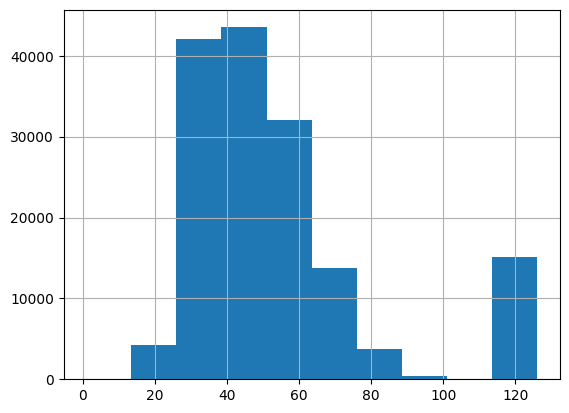

In [12]:
dem_com['age'].hist()

In [9]:
# capping age as typically individuals below 20 and above 65 aren't considered for a loan
# there are also some ages above 70 that might not seem true
dem_com['age'] = dem_com['age'].clip(20, 65)
dem_com['age'].describe()

count   154849.00
mean        47.55
std         12.95
min         20.00
25%         37.00
50%         47.00
75%         61.00
max         65.00
Name: age, dtype: float64

In [10]:
# dividing the datasets into starter and non-starter datasets for modelling
st_mdf = dem_com[dem_com['account_status']=='Starter'][['Loan Id',tar_col]+mcols].set_index('Loan Id')
nst_mdf = dem_com[dem_com['account_status']=='Non-starter'][['Loan Id',tar_col]+mcols].set_index('Loan Id')
print (st_mdf.shape, nst_mdf.shape)

(457, 26) (154392, 26)


In [11]:
# creating a list on initial features to be used in the starter model
st_mcols = ['principal_reduction_ratio', 'days_since_chargeoff', 'email_sent_delivered_ratio', 
            'communication_vintage', 'no_balance_reduction_flag', 'days_since_last_contact', 
            'days_since_last_email_read', 'last_payment_to_balance', 'rpc_rate', 'days_since_last_payment',
            'sms_sent_delivered_ratio', 'age', 'ptp_rate', 'days_bw_chargeoff_last_pmt', 'drop_rate', 
            'principal_reduction', 'balance_ratio', 'total_payment_to_original', 'connect_rate', 
            'was_email_used', 'days_bw_last_notice_last_pmt', 'email_delivered_read_ratio', 'days_since_last_sms_delivered', 'was_sms_used']
print (len(st_mcols))
print (st_mcols)

24
['principal_reduction_ratio', 'days_since_chargeoff', 'email_sent_delivered_ratio', 'communication_vintage', 'no_balance_reduction_flag', 'days_since_last_contact', 'days_since_last_email_read', 'last_payment_to_balance', 'rpc_rate', 'days_since_last_payment', 'sms_sent_delivered_ratio', 'age', 'ptp_rate', 'days_bw_chargeoff_last_pmt', 'drop_rate', 'principal_reduction', 'balance_ratio', 'total_payment_to_original', 'connect_rate', 'was_email_used', 'days_bw_last_notice_last_pmt', 'email_delivered_read_ratio', 'days_since_last_sms_delivered', 'was_sms_used']


In [12]:
# creating a list on initial features to be used in the non-starter model
nst_mcols = ['principal_reduction_ratio', 'days_since_chargeoff', 'email_sent_delivered_ratio', 'communication_vintage', 
             'no_balance_reduction_flag', 'days_since_last_contact', 'days_since_last_email_read', 'last_payment_to_balance',
             'rpc_rate', 'days_since_last_payment', 'sms_sent_delivered_ratio', 'age', 'ptp_rate', 'days_bw_chargeoff_last_pmt',
             'drop_rate', 'principal_reduction', 'balance_ratio', 'total_payment_to_original', 'connect_rate', 'was_email_used',
             'days_bw_last_notice_last_pmt', 'email_delivered_read_ratio', 'days_since_last_sms_delivered', 'was_sms_used',
             'was_email_or_sms_used']

# assuming non-starters have made little to no payment which is also reflected in the data as the most of the features derived through
# payment amounts have mostly zeroes in them and so excluding these features from the model
# also excluding features made on last payment date as non-starters will not have a last payment date

nst_rem_cols = ['principal_reduction_ratio','no_balance_reduction_flag','last_payment_to_balance','principal_reduction',
                'total_payment_to_original','days_since_last_payment','days_bw_chargeoff_last_pmt','days_bw_last_notice_last_pmt']

nst_mcols = [c for c in nst_mcols if c not in nst_rem_cols]
print (len(nst_mcols))
print (nst_mcols)

17
['days_since_chargeoff', 'email_sent_delivered_ratio', 'communication_vintage', 'days_since_last_contact', 'days_since_last_email_read', 'rpc_rate', 'sms_sent_delivered_ratio', 'age', 'ptp_rate', 'drop_rate', 'balance_ratio', 'connect_rate', 'was_email_used', 'email_delivered_read_ratio', 'days_since_last_sms_delivered', 'was_sms_used', 'was_email_or_sms_used']


In [13]:
# checking proportion of null values as well as 0's in each of the starter features
st_notna = (st_mdf[st_mcols].notna().sum()/len(st_mdf)).reset_index()

for c in st_mcols:
    if len(st_mdf[st_mdf[c]==0])/len(st_mdf)>0.5:
        print (c, len(st_mdf[st_mdf[c]==0])/len(st_mdf))
        
st_notna[st_notna[0]>=0.2]
# st_notna[st_notna[0]<0.2]

no_balance_reduction_flag 0.9715536105032823
drop_rate 0.7396061269146609
total_payment_to_original 0.5864332603938731


,index,0
0,principal_reduction_ratio,1.00
1,days_since_chargeoff,1.00
4,no_balance_reduction_flag,1.00
7,last_payment_to_balance,1.00
8,rpc_rate,0.68
9,days_since_last_payment,1.00
11,age,1.00
12,ptp_rate,0.44
13,days_bw_chargeoff_last_pmt,1.00
14,drop_rate,0.80


In [14]:
# checking proportion of null values as well as 0's in each of the non-starter features
nst_notna = (nst_mdf[nst_mcols].notna().sum()/len(nst_mdf)).reset_index()

for c in nst_mcols:
    if len(nst_mdf[nst_mdf[c]==0])/len(nst_mdf)>0.5:
        print (c, len(nst_mdf[nst_mdf[c]==0])/len(nst_mdf))
        
nst_notna[nst_notna[0]>=0.2]
nst_notna[nst_notna[0]<0.2]

drop_rate 0.7718923260272553
was_email_or_sms_used 0.8908363127623193


,index,0
1,email_sent_delivered_ratio,0.05
2,communication_vintage,0.11
3,days_since_last_contact,0.11
4,days_since_last_email_read,0.01
6,sms_sent_delivered_ratio,0.05
12,was_email_used,0.11
13,email_delivered_read_ratio,0.01
14,days_since_last_sms_delivered,0.06
15,was_sms_used,0.11


In [15]:
# fill-rates for features where an email or sms was sent are very low since these mediums of communication 
# were only used for 16917 loan ids and so the flags was_sms_used and was_email_used can be helpful in giving 
# information to the model regarding such low fill-rates
# So, filling nulls in these two flag features by zeros
st_mdf['was_email_used'] = st_mdf['was_email_used'].fillna(0)
st_mdf['was_sms_used'] = st_mdf['was_sms_used'].fillna(0)

nst_mdf['was_email_used'] = nst_mdf['was_email_used'].fillna(0)
nst_mdf['was_sms_used'] = nst_mdf['was_sms_used'].fillna(0)

In [16]:
# computing pearson's correlation in between the starter features and the target variable
corr_df = st_mdf[st_mcols+[tar_col]].corr()
corr_df = corr_df[tar_col].reset_index()
corr_df = corr_df[corr_df['index']!=tar_col].reset_index(drop=True)
corr_df

,index,payment
0,principal_reduction_ratio,0.16
1,days_since_chargeoff,-0.05
2,email_sent_delivered_ratio,-0.11
3,communication_vintage,0.14
4,no_balance_reduction_flag,0.20
5,days_since_last_contact,-0.17
6,days_since_last_email_read,-0.11
7,last_payment_to_balance,0.12
8,rpc_rate,0.08
9,days_since_last_payment,-0.46


In [585]:
# looking at the top positively correlated features
corr_df[corr_df[tar_col]>0.1]

,index,payment
0,principal_reduction_ratio,0.16
3,communication_vintage,0.14
4,no_balance_reduction_flag,0.20
7,last_payment_to_balance,0.12
12,ptp_rate,0.12
17,total_payment_to_original,0.43
22,days_since_last_sms_delivered,0.27
23,was_sms_used,0.12


In [586]:
# looking at the top negatively correlated features
corr_df[corr_df[tar_col]<-0.1]

,index,payment
2,email_sent_delivered_ratio,-0.11
5,days_since_last_contact,-0.17
6,days_since_last_email_read,-0.11
9,days_since_last_payment,-0.46
16,balance_ratio,-0.16
21,email_delivered_read_ratio,-0.10


In [17]:
# computing pearson's correlation in between the non-starter features and the target variable
corr_df = nst_mdf[nst_mcols+[tar_col]].corr()
corr_df = corr_df[tar_col].reset_index()
corr_df = corr_df[corr_df['index']!=tar_col].reset_index(drop=True)
corr_df

,index,payment
0,days_since_chargeoff,-0.01
1,email_sent_delivered_ratio,0.00
2,communication_vintage,0.01
3,days_since_last_contact,-0.00
4,days_since_last_email_read,0.03
5,rpc_rate,0.02
6,sms_sent_delivered_ratio,0.01
7,age,0.01
8,ptp_rate,0.12
9,drop_rate,-0.00


In [588]:
# looking at the top positively correlated features
corr_df[corr_df[tar_col]>0.1]

,index,payment
8,ptp_rate,0.12


In [589]:
# looking at the top negatively correlated features
corr_df[corr_df[tar_col]<-0.1]

,index,payment
10,balance_ratio,-0.36


### Non-starter model

In [323]:
# Features for the non-starter model
nst_mcols = ['principal_reduction_ratio', 'days_since_chargeoff', 'email_sent_delivered_ratio', 'communication_vintage', 
             'no_balance_reduction_flag', 'days_since_last_contact', 'days_since_last_email_read', 'last_payment_to_balance',
             'rpc_rate', 'days_since_last_payment', 'sms_sent_delivered_ratio', 'age', 'ptp_rate', 'days_bw_chargeoff_last_pmt',
             'drop_rate', 'principal_reduction', 'balance_ratio', 'total_payment_to_original', 'connect_rate', 'was_email_used',
             'days_bw_last_notice_last_pmt', 'email_delivered_read_ratio', 'days_since_last_sms_delivered', 'was_sms_used',
             'was_email_or_sms_used']

# assuming non-starters have made little to no payment which is also reflected in the data as the most of the features derived through
# payment amounts have mostly zeroes in them and so excluding these feartures from the model
# also excluding features made on last payment date as non-starters will not have a last payment date

nst_rem_cols = ['principal_reduction_ratio','no_balance_reduction_flag','last_payment_to_balance','principal_reduction',
                'total_payment_to_original','days_since_last_payment','days_bw_chargeoff_last_pmt','days_bw_last_notice_last_pmt',
               'was_email_or_sms_used']

nst_mcols = [c for c in nst_mcols if c not in nst_rem_cols]

print ('FEATURES USED IN THE MODEL :', nst_mcols,'\n')
print ('NO OF FEATURES :', len(nst_mcols))

FEATURES USED IN THE MODEL : ['days_since_chargeoff', 'email_sent_delivered_ratio', 'communication_vintage', 'days_since_last_contact', 'days_since_last_email_read', 'rpc_rate', 'sms_sent_delivered_ratio', 'age', 'ptp_rate', 'drop_rate', 'balance_ratio', 'connect_rate', 'was_email_used', 'email_delivered_read_ratio', 'days_since_last_sms_delivered', 'was_sms_used'] 

NO OF FEATURES : 16


In [260]:
# creating some general flags to be used in the model initially like no-scaling, binary-class model, do cross-validation, etc.
scale = True
scale = False

multi_class = False
# multi_class = True

use_cv = True
# use_cv = False

test_size = 0.3

random_state = 42

=== LOG-REG PARAMS ===
{'solver': 'lbfgs', 'max_iter': 200, 'random_state': 42}
Model used : LG


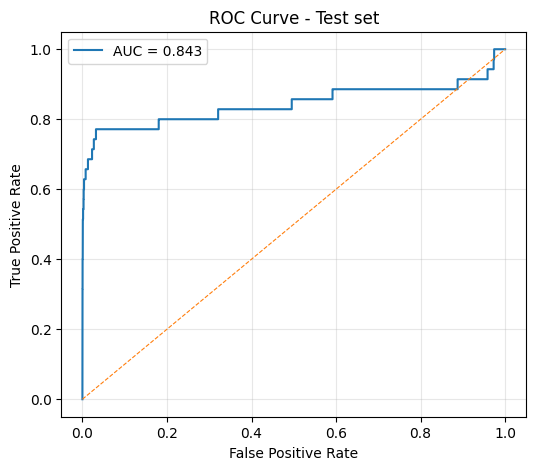

In [261]:
# LOG-REG PARAMETERS (doing some initial manual parameter tuning)
class_weights = {0:1, 1:200}

max_iter=2000
max_iter=200

solver = 'lbfgs'

params = {
    'solver' : solver,
    'max_iter' : max_iter,
    # 'class_weight' : class_weights,
    'random_state' : random_state
}
    
print ('=== LOG-REG PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=nst_mdf,
    tar_col="payment",
    mcols=nst_mcols,
    scale=scale,
    params=params
)

In [262]:
# Cross-validation metrics
print ('CV Scores :', results['cv_scores'])
results["cv_summary"]

CV Scores : [0.98205963 0.7880359  0.9805558  0.88871778 0.88594394]


,roc_auc
mean,0.91
std,0.08


In [263]:
# train AUC
results["train_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,1.00,1.00,0.01,0.01,0.91


In [264]:
# test AUC
results["test_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,1.00,0.00,0.00,0.00,0.84


In [265]:
# feature weights or importance as derived by the model
results["feature_importance"]

,feature,coef,abs_coef,orig_col
0,connect_rate,0.15,0.15,connect_rate
1,rpc_rate,0.14,0.14,rpc_rate
2,ptp_rate,0.13,0.13,ptp_rate
3,age,0.04,0.04,age
4,email_sent_delivered_ratio,0.02,0.02,email_sent_delivered_ratio
5,sms_sent_delivered_ratio,0.01,0.01,sms_sent_delivered_ratio
6,days_since_last_email_read,0.01,0.01,days_since_last_email_read
7,communication_vintage,0.00,0.00,communication_vintage
8,days_since_chargeoff,-0.00,0.00,days_since_chargeoff
9,days_since_last_sms_delivered,-0.00,0.00,days_since_last_sms_delivered


=== DT PARAMS ===
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 200, 'min_samples_split': 5000, 'class_weight': 'balanced', 'random_state': 42}
Model used : DT


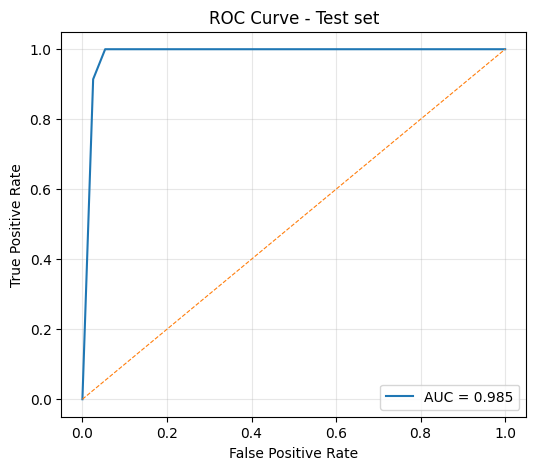

In [266]:
# DT PARAMS
criterion = 'gini'

max_depth = 3
# max_depth = 11

min_samples_leaf = 200
min_samples_split = 5000

class_weight = 'balanced'

params = {
    'criterion': criterion, 
    'max_depth': max_depth, 
    'min_samples_leaf': min_samples_leaf, 
    'min_samples_split': min_samples_split,
    'class_weight' : class_weight,
    'random_state' : random_state
}
print ('=== DT PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=nst_mdf,
    tar_col="payment",
    mcols=nst_mcols,
    scale=scale,
    dt=True,
    params=params
)

In [267]:
# Cross-validation metrics
print ('CV Scores :', results['cv_scores'])
results["cv_summary"]

CV Scores : [0.98463598 0.98984947 0.98486033 0.97030208 0.98593718]


,roc_auc
mean,0.98
std,0.01


In [268]:
# train AUC
results["train_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.97,0.04,0.99,0.07,0.99


In [269]:
# test AUC
results["test_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.97,0.04,0.91,0.08,0.99


In [270]:
# feature importance
results["feature_importance"]

,feature,gain,orig_col
10,balance_ratio,0.97,balance_ratio
0,days_since_chargeoff,0.03,days_since_chargeoff
2,communication_vintage,0.00,communication_vintage
1,email_sent_delivered_ratio,0.00,email_sent_delivered_ratio
4,days_since_last_email_read,0.00,days_since_last_email_read
5,rpc_rate,0.00,rpc_rate
6,sms_sent_delivered_ratio,0.00,sms_sent_delivered_ratio
3,days_since_last_contact,0.00,days_since_last_contact
7,age,0.00,age
8,ptp_rate,0.00,ptp_rate


=== RF PARAMS ===
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 200, 'min_samples_split': 5000, 'class_weight': 'balanced', 'random_state': 42}
Model used : RF


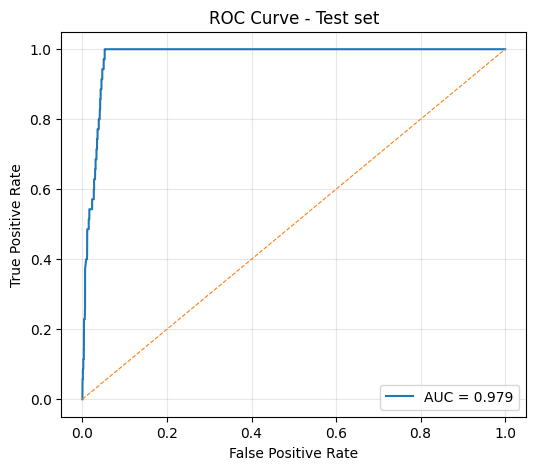

In [271]:
# RF PARAMS
criterion = 'gini'

max_depth = 3
# max_depth = 11

min_samples_leaf = 200
min_samples_split = 5000

class_weight = 'balanced'

params = {
    'criterion': criterion, 
    'max_depth': max_depth, 
    'min_samples_leaf': min_samples_leaf, 
    'min_samples_split': min_samples_split,
    'class_weight' : class_weight,
    'random_state' : random_state
}
print ('=== RF PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=nst_mdf,
    tar_col="payment",
    mcols=nst_mcols,
    scale=scale,
    rf=True,
    params=params
)

In [272]:
# feature importance
results["feature_importance"]

,feature,gain,orig_col
10,balance_ratio,0.62,balance_ratio
5,rpc_rate,0.09,rpc_rate
11,connect_rate,0.09,connect_rate
0,days_since_chargeoff,0.07,days_since_chargeoff
7,age,0.06,age
9,drop_rate,0.02,drop_rate
14,days_since_last_sms_delivered,0.02,days_since_last_sms_delivered
3,days_since_last_contact,0.02,days_since_last_contact
1,email_sent_delivered_ratio,0.01,email_sent_delivered_ratio
4,days_since_last_email_read,0.01,days_since_last_email_read


=== XGB PARAMS ===
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'scale_pos_weight': 20000, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.2, 'colsample_bytree': 0.6, 'max_features': 9, 'random_state': 42, 'n_jobs': -1}
Model used : XGB


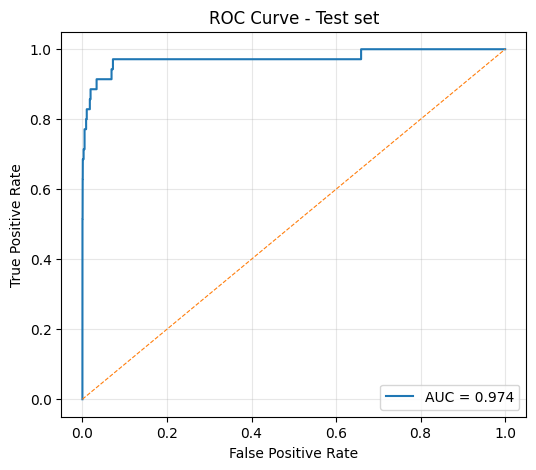

In [273]:
# XGB PARAMS
objective="multi:softprob"
eval_metric="mlogloss"

n_estimators = 300
n_estimators = 200

max_depth=3
max_depth=6

learning_rate=0.05
learning_rate=0.01
# learning_rate=0.005

subsample=0.2
# subsample=0.5

colsample_bytree=1.0
colsample_bytree=0.6

max_features = 6
max_features = 9

n_jobs=-1

reg_alpha = 0.5   # L1 regularization
reg_alpha = 1.0   # L1 regularization

reg_lambda = 1.0  # L2 regularization

# pos_weight = len(nst_mdf[nst_mdf[tar_col]==1])/len(nst_mdf[nst_mdf[tar_col]==0])
pos_weight = 20000

min_child_weight = 20
    
objective="binary:logistic"
eval_metric="logloss"
params = {
        'objective' : objective,
        'eval_metric' : eval_metric,
        'scale_pos_weight' : pos_weight,
        'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        # 'min_child_weight' : min_child_weight,
        'learning_rate' : learning_rate,
        'subsample' : subsample,
        'colsample_bytree' : colsample_bytree,
        'max_features' : max_features,
        'random_state' : random_state,
        'n_jobs' : -1
}

print ('=== XGB PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=nst_mdf,
    tar_col="payment",
    mcols=nst_mcols,
    scale=scale,
    xgb=True,
    params=params
)

In [274]:
# Cross-validation metrics
print ('CV Scores :', results['cv_scores'])
results["cv_summary"]

CV Scores : [0.99873643 0.99749168 0.99858156 0.90313032 0.96922661]


,roc_auc
mean,0.97
std,0.04


In [275]:
# train AUC
results["train_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.99,0.08,1.00,0.14,1.00


In [276]:
# test AUC
results["test_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.99,0.07,0.83,0.12,0.97


In [277]:
# feature importance
results["feature_importance"]

,feature,gain,orig_col
10,balance_ratio,0.62,balance_ratio
0,days_since_chargeoff,0.05,days_since_chargeoff
11,connect_rate,0.04,connect_rate
7,age,0.04,age
2,communication_vintage,0.04,communication_vintage
13,email_delivered_read_ratio,0.03,email_delivered_read_ratio
1,email_sent_delivered_ratio,0.02,email_sent_delivered_ratio
3,days_since_last_contact,0.02,days_since_last_contact
9,drop_rate,0.02,drop_rate
6,sms_sent_delivered_ratio,0.02,sms_sent_delivered_ratio


=== HGBM PARAMS ===
{'max_iter': 50, 'max_depth': 3, 'learning_rate': 0.01, 'min_samples_leaf': 10, 'l2_regularization': 0.2, 'random_state': 42}
Model used : HGBGM


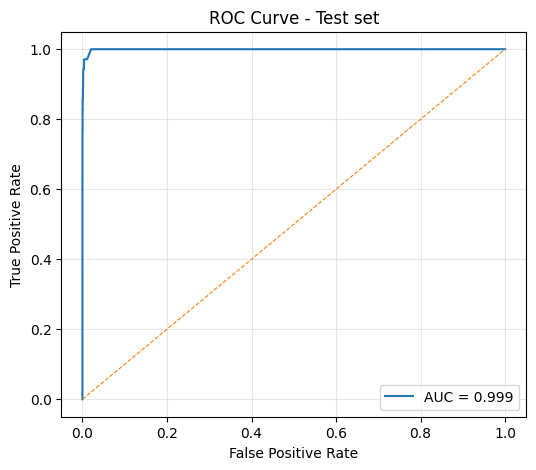

In [278]:
# HGBM
max_iter=50
max_depth=3
learning_rate=0.01
min_samples_leaf=10
l2=0.2
# monotonic_cst=monotonic_cst(OWNER_FEATURES)

params = {
    'max_iter' : max_iter,
    'max_depth' : max_depth,
    'learning_rate' : learning_rate,
    'min_samples_leaf' : min_samples_leaf,
    'l2_regularization' : l2,
    'random_state' : random_state
}
print ('=== HGBM PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=nst_mdf,
    tar_col="payment",
    mcols=nst_mcols,
    scale=scale,
    hgbm=True,
    params=params
)

In [279]:
# feature importance
results["feature_importance"]

,feature,importance_mean,importance_std
10,balance_ratio,0.47,0.01
0,days_since_chargeoff,0.01,0.00
9,drop_rate,0.00,0.00
7,age,0.00,0.00
5,rpc_rate,0.00,0.00
4,days_since_last_email_read,0.00,0.00
3,days_since_last_contact,0.00,0.00
1,email_sent_delivered_ratio,0.00,0.00
14,days_since_last_sms_delivered,0.00,0.00
6,sms_sent_delivered_ratio,0.00,0.00


#### Final model

=== LOG-REG PARAMS ===
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.5, 'class_weight': {0: 1, 1: 500}, 'max_iter': 1000, 'random_state': 42}
Model used : LG


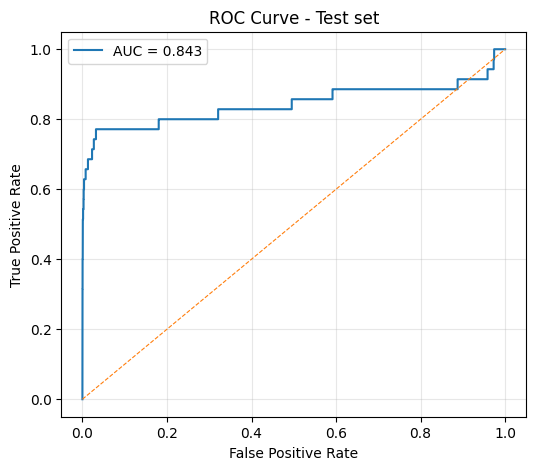

In [321]:
# LOG-REG PARAMS
# PARAMETER TUNING
# class_weight={0: 1, 1: 5}
class_weight={0: 1, 1: 500}

max_iter=1000

c = 0.01
# c = 10

# l1_ratio = 0.2
# l1_ratio = 0.8
# l1_ratio = 0
# l1_ratio = 1

# FOR L1-REG
# solver="liblinear"
# penalty = "l1"
# c = 0.1

# FOR L2-REG
solver="lbfgs"
penalty = "l2"
# c = 1.0

# FOR MIX OF BOTH L1 AND L2
# solver="saga"
# penalty="elasticnet"
# l1_ratio=0.5 # 0 = pure L2, 1 = pure L1
c = 0.5

params = {
    "solver" : solver, 
    "penalty" : penalty,
    # "l1_ratio" : l1_ratio,
    "C" : c, 
    "class_weight" : class_weight, 
    "max_iter" : max_iter,
    "random_state" : random_state
}
    
print ('=== LOG-REG PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=nst_mdf,
    tar_col="payment",
    mcols=nst_mcols,
    scale=scale,
    params=params
)

model = results['model']
y_train = results['y_train']
y_test = results['y_test']
y_proba_train = results['y_train_proba']
y_proba_test = results['y_test_proba']
X_train_processed = results['X_train_processed']
X_test_processed = results['X_test_processed']

In [325]:
# Computing shap values and wald-chi sq test values for feature selection and along with them analysing the model-coefficients
feat_df = results['feature_importance']

sample_weight = y_train.copy()

X_sm = sm.add_constant(X_train_processed)

logit = sm.Logit(
    y_train,
    X_sm,
    freq_weights=sample_weight
)

res = logit.fit(maxiter=max_iter)

summary_df = res.summary2().tables[1]

summary_df["wald_chi2"] = (summary_df["Coef."] / summary_df["Std.Err."])**2
wald_chi = summary_df[["Coef.", "Std.Err.", "wald_chi2", "P>|z|"]].reset_index().sort_values('wald_chi2',ascending=False)
wald_chi.rename(columns={'index':'feature'},inplace=True)

explainer = shap.LinearExplainer(
    model, 
    X_train_processed,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(X_test_processed)

shap_array = np.array(shap_values)

shap_importance = pd.DataFrame({
    "feature": X_test_processed.columns,
    "mean_abs_shap": np.abs(shap_array).mean(axis=0),
    "mean_shap": shap_array.mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

feat_df_cols = ['feature','coef','orig_col']
feat_df2 = feat_df[feat_df_cols].sort_values('coef',ascending=False)
feat_df2 = pd.merge(feat_df2, wald_chi, on='feature', how='left')
feat_df2 = pd.merge(feat_df2, shap_importance, on='feature', how='left')
feat_df2

Optimization terminated successfully.
         Current function value: 0.002978
         Iterations 14


,feature,coef,orig_col,Coef.,Std.Err.,wald_chi2,P>|z|,mean_abs_shap,mean_shap
0,connect_rate,0.15,connect_rate,2.66,0.48,30.47,0.00,0.02,0.00
1,rpc_rate,0.14,rpc_rate,0.31,0.77,0.16,0.69,0.00,0.00
2,ptp_rate,0.13,ptp_rate,4.60,1.10,17.38,0.00,0.00,0.00
3,age,0.04,age,-0.00,0.01,0.02,0.88,0.46,0.06
4,email_sent_delivered_ratio,0.02,email_sent_delivered_ratio,-0.00,0.01,0.29,0.59,0.12,0.03
5,sms_sent_delivered_ratio,0.01,sms_sent_delivered_ratio,-0.02,0.01,1.79,0.18,0.04,0.02
6,days_since_last_email_read,0.01,days_since_last_email_read,0.01,0.01,1.46,0.23,0.01,0.01
7,communication_vintage,0.00,communication_vintage,0.01,0.00,6.84,0.01,0.01,0.00
8,days_since_chargeoff,-0.00,days_since_chargeoff,0.00,0.00,21.84,0.00,0.27,-0.05
9,days_since_last_sms_delivered,-0.00,days_since_last_sms_delivered,0.01,0.01,1.64,0.20,0.01,-0.00


In [326]:
# Checking for correlation (pearson's R) between the features used in the model
corr_df = pd.concat([X_train_processed, X_test_processed], ignore_index=True).corr(method='pearson')
corr_df2 = corr_df[(corr_df>0.7)|(corr_df<-0.7)] .fillna(0)

threshold = 0.7
# threshold = 0.6
high_corr_dict = {}

for c in corr_df2.columns:
    high_corr = (
        corr_df2[c].drop(labels=[c]).loc[lambda x : x>threshold]
    )
    
    if not high_corr.empty:
        high_corr_dict[c] = high_corr.round(3).to_dict()
        
high_corr_df = pd.DataFrame({
    'feature': high_corr_dict.keys(),
    'high_corr_features': high_corr_dict.values()
})
high_corr_df

,feature,high_corr_features
0,email_sent_delivered_ratio,{'was_email_used': 0.739}
1,communication_vintage,"{'sms_sent_delivered_ratio': 0.71, 'was_email_used': 0.725, 'was_sms_used': 0.84}"
2,days_since_last_email_read,{'email_delivered_read_ratio': 0.715}
3,sms_sent_delivered_ratio,"{'communication_vintage': 0.71, 'was_sms_used': 0.831}"
4,was_email_used,"{'email_sent_delivered_ratio': 0.739, 'communication_vintage': 0.725}"
5,email_delivered_read_ratio,{'days_since_last_email_read': 0.715}
6,was_sms_used,"{'communication_vintage': 0.84, 'sms_sent_delivered_ratio': 0.831}"


In [327]:
# highly correlated features to be removed : days_since_last_email_read , email_sent_delivered_ratio

In [328]:
# CALCUALTING VIF FOR MULTI-COLLINEARITY
new_cols_to_rem = []
# new_cols_to_rem = ['communication_vintage','was_sms_used']
# final_cols_for_vif = [c for c in X_train_processed.columns if c not in new_cols_to_rem]

# X2 = add_constant(X_train_processed[final_cols_for_vif])   # adds intercept term
X2 = add_constant(X_train_processed)   # adds intercept term

vif_data = []
for i, col in enumerate(X2.columns):
    vif = variance_inflation_factor(X2.values, i)
    vif_data.append((col, vif))

vif_df = pd.DataFrame(vif_data, columns=['feature', 'VIF'])
vif_df.sort_values('VIF', ascending=False, inplace=True)
vif_df

,feature,VIF
0,const,319.28
3,communication_vintage,7.05
16,was_sms_used,6.82
13,was_email_used,4.53
7,sms_sent_delivered_ratio,3.34
2,email_sent_delivered_ratio,2.52
14,email_delivered_read_ratio,2.20
5,days_since_last_email_read,2.08
15,days_since_last_sms_delivered,1.92
4,days_since_last_contact,1.79


In [ ]:
# high VIF features to be removed : communication_vintage, was_sms_used

In [329]:
# FINAL FEATURE SELECTION
nst_mcols = ['principal_reduction_ratio', 'days_since_chargeoff', 'email_sent_delivered_ratio', 'communication_vintage', 
             'no_balance_reduction_flag', 'days_since_last_contact', 'days_since_last_email_read', 'last_payment_to_balance',
             'rpc_rate', 'days_since_last_payment', 'sms_sent_delivered_ratio', 'age', 'ptp_rate', 'days_bw_chargeoff_last_pmt',
             'drop_rate', 'principal_reduction', 'balance_ratio', 'total_payment_to_original', 'connect_rate', 'was_email_used',
             'days_bw_last_notice_last_pmt', 'email_delivered_read_ratio', 'days_since_last_sms_delivered', 'was_sms_used',
             'was_email_or_sms_used']

# assuming non-starters have made little to no payment which is also reflected in the data as the most of the features derived through
# payment amounts have mostly zeroes in them and so excluding these feartures from the model
# also excluding features made on last payment date as non-starters will not have a last payment date

nst_rem_cols = ['principal_reduction_ratio','no_balance_reduction_flag','last_payment_to_balance','principal_reduction',
                'total_payment_to_original','days_since_last_payment','days_bw_chargeoff_last_pmt','days_bw_last_notice_last_pmt',
               'was_email_or_sms_used']

nst_mcols = [c for c in nst_mcols if c not in nst_rem_cols]

# NO FEATURES WERE FOUND TO HAVE CO-EFFICIENTS (DIRECTIONALITY) THAT DID NOT MAKE INTUITIVE OR BUSINESS SENSE
# features like was_email_used have negative co-efficients because the end-user might be unresponsive
# which means that they chose to ignore emails
incorr_coef = []
nst_mcols = [c for c in nst_mcols if c not in incorr_coef]

# FEATURES FOUND TO BE HIGHLY CORRELATED WITH EACH OTHER THROUGH PEARSON'S R OR VIF
multi_coll_cols = ['communication_vintage','was_sms_used','days_since_last_email_read','email_sent_delivered_ratio']
nst_mcols = [c for c in nst_mcols if c not in multi_coll_cols]

print ('FEATURES USED IN THE MODEL :', nst_mcols,'\n')
print ('NO OF FEATURES :', len(nst_mcols))

FEATURES USED IN THE MODEL : ['days_since_chargeoff', 'days_since_last_contact', 'rpc_rate', 'sms_sent_delivered_ratio', 'age', 'ptp_rate', 'drop_rate', 'balance_ratio', 'connect_rate', 'was_email_used', 'email_delivered_read_ratio', 'days_since_last_sms_delivered'] 

NO OF FEATURES : 12


=== LOG-REG PARAMS ===
{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.5, 'class_weight': {0: 1, 1: 500}, 'max_iter': 1000, 'random_state': 42}
Model used : LG


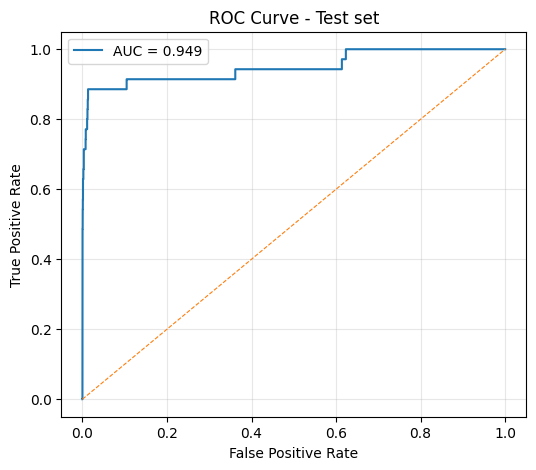

In [330]:
# running the model with the final parameters and features
class_weight={0: 1, 1: 500}
max_iter=1000
solver="lbfgs"
penalty = "l2"
c = 0.5

params = {
    "solver" : solver, 
    "penalty" : penalty,
    "C" : c, 
    "class_weight" : class_weight, 
    "max_iter" : max_iter,
    "random_state" : random_state
}
    
print ('=== LOG-REG PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=nst_mdf,
    tar_col="payment",
    mcols=nst_mcols,
    scale=scale,
    params=params
)

model = results['model']
y_train = results['y_train']
y_test = results['y_test']
y_proba_train = results['y_train_proba']
y_proba_test = results['y_test_proba']
X_train_processed = results['X_train_processed']
X_test_processed = results['X_test_processed']

In [331]:
# Cross-validation metrics
print ('CV Scores :', results['cv_scores'])
results["cv_summary"]

CV Scores : [0.97190766 0.94026632 0.98050224 0.91067282 0.94861946]


,roc_auc
mean,0.95
std,0.03


In [332]:
# train AUC
results['train_metrics']

,accuracy,precision,recall,f1,roc_auc
0,1.00,0.76,0.21,0.33,0.96


In [333]:
# test AUC
results['test_metrics']

,accuracy,precision,recall,f1,roc_auc
0,1.00,0.60,0.26,0.36,0.95


In [334]:
# Computing shap values and wald-chi sq test values for feature selection and along with them analysing the model-coefficients
feat_df = results['feature_importance']

sample_weight = y_train.copy()

X_sm = sm.add_constant(X_train_processed)

logit = sm.Logit(
    y_train,
    X_sm,
    freq_weights=sample_weight
)

res = logit.fit(maxiter=max_iter)

summary_df = res.summary2().tables[1]

summary_df["wald_chi2"] = (summary_df["Coef."] / summary_df["Std.Err."])**2
wald_chi = summary_df[["Coef.", "Std.Err.", "wald_chi2", "P>|z|"]].reset_index().sort_values('wald_chi2',ascending=False)
wald_chi.rename(columns={'index':'feature'},inplace=True)

explainer = shap.LinearExplainer(
    model, 
    X_train_processed,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(X_test_processed)

shap_array = np.array(shap_values)

shap_importance = pd.DataFrame({
    "feature": X_test_processed.columns,
    "mean_abs_shap": np.abs(shap_array).mean(axis=0),
    "mean_shap": shap_array.mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

feat_df_cols = ['feature','coef','orig_col']
feat_df2 = feat_df[feat_df_cols].sort_values('coef',ascending=False)
feat_df2 = pd.merge(feat_df2, wald_chi, on='feature', how='left')
feat_df2 = pd.merge(feat_df2, shap_importance, on='feature', how='left')
feat_df2

Optimization terminated successfully.
         Current function value: 0.003010
         Iterations 13


,feature,coef,orig_col,Coef.,Std.Err.,wald_chi2,P>|z|,mean_abs_shap,mean_shap
0,connect_rate,0.54,connect_rate,2.65,0.48,30.08,0.00,0.05,0.00
1,rpc_rate,0.32,rpc_rate,0.36,0.78,0.21,0.65,0.01,0.00
2,ptp_rate,0.28,ptp_rate,4.44,1.12,15.81,0.00,0.00,0.00
3,age,0.09,age,-0.00,0.01,0.02,0.89,1.05,0.14
4,sms_sent_delivered_ratio,0.02,sms_sent_delivered_ratio,-0.02,0.01,3.29,0.07,0.09,0.03
5,email_delivered_read_ratio,0.01,email_delivered_read_ratio,0.02,0.01,4.02,0.04,0.02,0.00
6,days_since_last_contact,0.00,days_since_last_contact,-0.00,0.01,0.22,0.64,0.02,0.00
7,days_since_chargeoff,0.00,days_since_chargeoff,0.00,0.00,23.33,0.00,0.13,0.02
8,days_since_last_sms_delivered,-0.03,days_since_last_sms_delivered,0.01,0.01,0.63,0.43,0.14,-0.07
9,drop_rate,-0.05,drop_rate,-19.66,10.80,3.32,0.07,0.00,-0.00


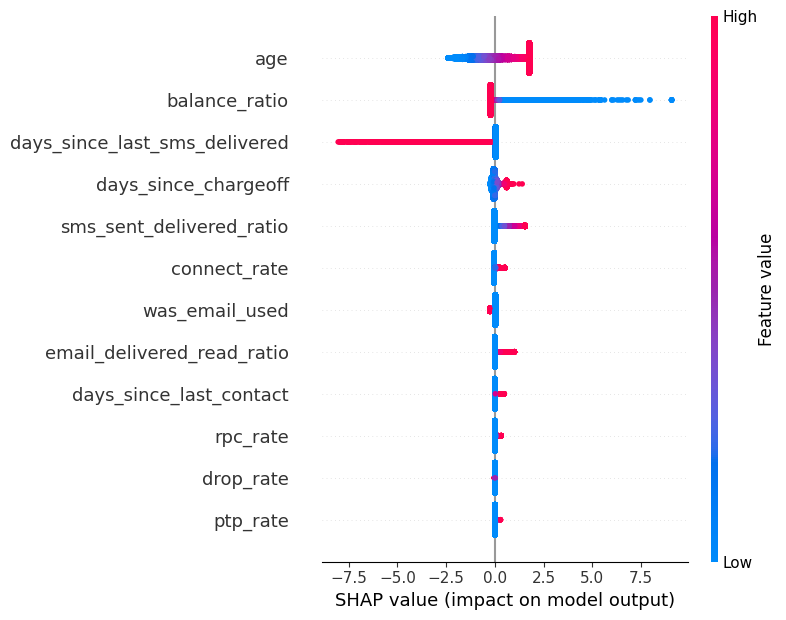

In [335]:
shap.summary_plot(shap_values, X_test_processed)

#### Final Testing Metrics

In [341]:
# at every probability cut-off between 0 to 100, calculating precision, recall, specificity to identify the ideal cut-off 
# that can be used to classify whether an individual will pay or not
cut_off = np.linspace(0,1,100)
train_df, train_metrics_df = get_metrics(X_train_processed, 'Train Probability', cut_off, y_train, model, tar_col, type_= None)

In [342]:
# analysing metrics as various cut-offs
train_metrics_df.head(30)

,gini,probability cut offs,Precision,Recall,Accuracy,Specificity,True positive predictions,True negative predictions,False positive predictions,False negative predictions
0,0.92,0.00,0.00,1.00,0.11,0.00,138,0,123375,0
1,0.92,0.01,0.13,0.81,99.38,99.40,112,122637,738,26
2,0.92,0.02,0.21,0.72,99.66,99.69,100,122995,380,38
3,0.92,0.03,0.28,0.69,99.77,99.80,95,123133,242,43
4,0.92,0.04,0.34,0.65,99.82,99.86,90,123198,177,48
5,0.92,0.05,0.37,0.62,99.84,99.88,85,123231,144,53
6,0.92,0.06,0.41,0.57,99.86,99.91,78,123264,111,60
7,0.92,0.07,0.45,0.54,99.87,99.93,75,123283,92,63
8,0.92,0.08,0.48,0.53,99.88,99.94,73,123297,78,65
9,0.92,0.09,0.51,0.50,99.89,99.95,69,123308,67,69


In [343]:
# on looking at these metrics, a probability cut-off of 22% can be suggested as at that threshold, we observed decent
# precision as well as we are able to capture ~35% of the individual that have actually made a payment
# at this cut-off, the true negative rate is also good
# in this scenario, it is important for Precision to be decent more importantly, because low Precision means higher False Positives which 
# is riskier because de-prioritizing people that are actually not going to pay back, which could mean increased losses

In [346]:
# checking if the performance on the test-set at the selected cut-off is similar or not
test_df, test_metrics_df = get_metrics(X_test_processed, 'Test Probability', cut_off, y_test, model, tar_col, type_= None)
test_metrics_df[test_metrics_df.index==22]

,gini,probability cut offs,Precision,Recall,Accuracy,Specificity,True positive predictions,True negative predictions,False positive predictions,False negative predictions
22,0.90,0.22,0.62,0.46,99.91,99.97,16,30834,10,19


In [347]:
# performance of the train-set at the selected cut-off
train_metrics_df[train_metrics_df.index==22]

,gini,probability cut offs,Precision,Recall,Accuracy,Specificity,True positive predictions,True negative predictions,False positive predictions,False negative predictions
22,0.92,0.22,0.65,0.34,99.91,99.98,47,123350,25,91


### Starter model

In [371]:
st_mcols = ['principal_reduction_ratio', 'days_since_chargeoff', 'email_sent_delivered_ratio', 
            'communication_vintage', 'no_balance_reduction_flag', 'days_since_last_contact', 
            'days_since_last_email_read', 'last_payment_to_balance', 'rpc_rate', 'days_since_last_payment',
            'sms_sent_delivered_ratio', 'age', 'ptp_rate', 'days_bw_chargeoff_last_pmt', 'drop_rate', 
            'principal_reduction', 'balance_ratio', 'total_payment_to_original', 'connect_rate', 
            'was_email_used', 'days_bw_last_notice_last_pmt', 'email_delivered_read_ratio', 'days_since_last_sms_delivered', 'was_sms_used']

# REMOVING THESE FEATURES AS THE MODEL OVERFITS ON THEM
st_rem_cols = ['days_since_last_payment', 'total_payment_to_original']
st_mcols = [c for c in st_mcols if c not in st_rem_cols]

print ('FEATURES USED IN THE MODEL :', st_mcols,'\n')
print ('NO OF FEATURES :', len(st_mcols))

FEATURES USED IN THE MODEL : ['principal_reduction_ratio', 'days_since_chargeoff', 'email_sent_delivered_ratio', 'communication_vintage', 'no_balance_reduction_flag', 'days_since_last_contact', 'days_since_last_email_read', 'last_payment_to_balance', 'rpc_rate', 'sms_sent_delivered_ratio', 'age', 'ptp_rate', 'days_bw_chargeoff_last_pmt', 'drop_rate', 'principal_reduction', 'balance_ratio', 'connect_rate', 'was_email_used', 'days_bw_last_notice_last_pmt', 'email_delivered_read_ratio', 'days_since_last_sms_delivered', 'was_sms_used'] 

NO OF FEATURES : 22


In [372]:
scale = True
scale = False

multi_class = False
# multi_class = True

use_cv = True
# use_cv = False

test_size = 0.3

random_state = 42

=== LOG-REG PARAMS ===
{'solver': 'lbfgs', 'max_iter': 200, 'random_state': 42}
Model used : LG


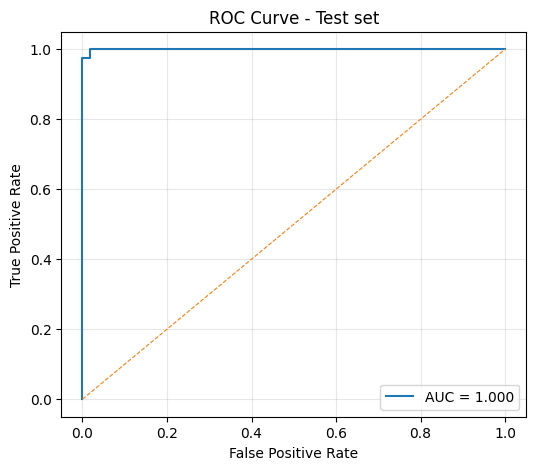

In [756]:
# LOG-REG PARAMS
class_weights = {0:1, 1:200}

max_iter=2000
max_iter=200

solver = 'lbfgs'

params = {
    'solver' : solver,
    'max_iter' : max_iter,
    # 'class_weight' : class_weights,
    'random_state' : random_state
}
    
print ('=== LOG-REG PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=st_mdf,
    tar_col="payment",
    mcols=st_mcols,
    scale=scale,
    params=params
)

In [757]:
print ('CV Scores :', results['cv_scores'])
results["cv_summary"]

CV Scores : [0.99462366 0.99001536 0.98294574 0.99069767 0.99457364]


,roc_auc
mean,0.99
std,0.00


In [758]:
results["train_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.96,0.97,0.93,0.95,1.00


In [759]:
results["test_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.99,1.00,0.97,0.99,1.00


In [760]:
results["feature_importance"]

,feature,coef,abs_coef,orig_col
0,days_bw_chargeoff_last_pmt,0.24,0.24,days_bw_chargeoff_last_pmt
1,age,0.13,0.13,age
2,days_since_last_sms_delivered,0.04,0.04,days_since_last_sms_delivered
3,email_delivered_read_ratio,0.02,0.02,email_delivered_read_ratio
4,communication_vintage,0.02,0.02,communication_vintage
5,balance_ratio,0.01,0.01,balance_ratio
6,connect_rate,0.01,0.01,connect_rate
7,last_payment_to_balance,0.00,0.00,last_payment_to_balance
8,days_bw_last_notice_last_pmt,0.00,0.00,days_bw_last_notice_last_pmt
9,no_balance_reduction_flag,0.00,0.00,no_balance_reduction_flag


=== DT PARAMS ===
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 50, 'class_weight': 'balanced', 'random_state': 42}
Model used : DT


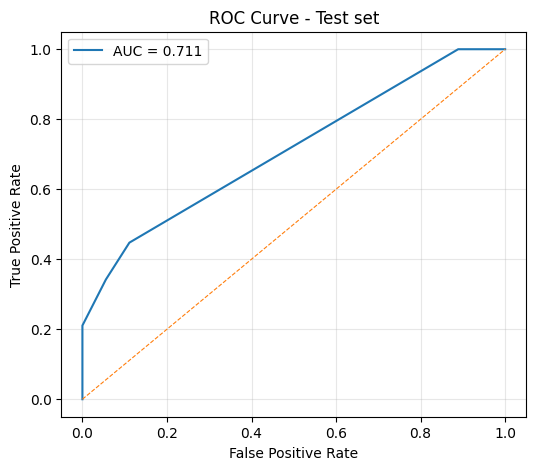

In [767]:
# DT PARAMS
criterion = 'gini'

max_depth = 3
# max_depth = 11

min_samples_leaf = 20
min_samples_split = 50

class_weight = 'balanced'

params = {
    'criterion': criterion, 
    'max_depth': max_depth, 
    'min_samples_leaf': min_samples_leaf, 
    'min_samples_split': min_samples_split,
    'class_weight' : class_weight,
    'random_state' : random_state
}
print ('=== DT PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=st_mdf,
    tar_col="payment",
    mcols=st_mcols,
    scale=scale,
    dt=True,
    params=params
)

In [768]:
print ('CV Scores :', results['cv_scores'])
results["cv_summary"]

CV Scores : [0.7016129  0.72427035 0.71007752 0.70465116 0.81860465]


,roc_auc
mean,0.73
std,0.05


In [769]:
results["train_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.74,0.77,0.54,0.63,0.76


In [770]:
results["test_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.71,0.74,0.45,0.56,0.71


In [771]:
results["feature_importance"]

,feature,gain,orig_col
18,days_bw_last_notice_last_pmt,0.94,days_bw_last_notice_last_pmt
0,principal_reduction_ratio,0.06,principal_reduction_ratio
2,email_sent_delivered_ratio,0.00,email_sent_delivered_ratio
3,communication_vintage,0.00,communication_vintage
4,no_balance_reduction_flag,0.00,no_balance_reduction_flag
1,days_since_chargeoff,0.00,days_since_chargeoff
5,days_since_last_contact,0.00,days_since_last_contact
6,days_since_last_email_read,0.00,days_since_last_email_read
8,rpc_rate,0.00,rpc_rate
7,last_payment_to_balance,0.00,last_payment_to_balance


=== RF PARAMS ===
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 50, 'class_weight': 'balanced', 'random_state': 42}
Model used : RF


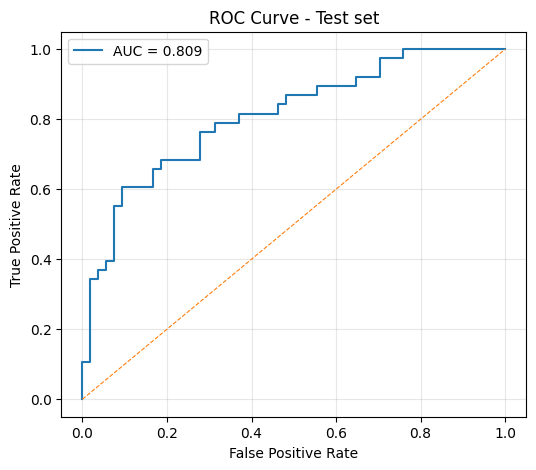

In [761]:
# RF PARAMS
criterion = 'gini'

max_depth = 4
# max_depth = 11

min_samples_leaf = 20
min_samples_split = 50

class_weight = 'balanced'

params = {
    'criterion': criterion, 
    'max_depth': max_depth, 
    'min_samples_leaf': min_samples_leaf, 
    'min_samples_split': min_samples_split,
    'class_weight' : class_weight,
    'random_state' : random_state
}
print ('=== RF PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=st_mdf,
    tar_col="payment",
    mcols=st_mcols,
    scale=scale,
    rf=True,
    params=params
)

In [763]:
print ('CV Scores :', results['cv_scores'])
results["cv_summary"]

CV Scores : [0.73579109 0.58602151 0.70620155 0.63643411 0.82790698]


,roc_auc
mean,0.70
std,0.09


In [764]:
results["train_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.78,0.70,0.82,0.75,0.86


In [765]:
results["test_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.68,0.58,0.82,0.68,0.81


In [762]:
results["feature_importance"]

,feature,gain,orig_col
18,days_bw_last_notice_last_pmt,0.22,days_bw_last_notice_last_pmt
12,days_bw_chargeoff_last_pmt,0.10,days_bw_chargeoff_last_pmt
1,days_since_chargeoff,0.10,days_since_chargeoff
15,balance_ratio,0.10,balance_ratio
7,last_payment_to_balance,0.10,last_payment_to_balance
14,principal_reduction,0.08,principal_reduction
10,age,0.08,age
0,principal_reduction_ratio,0.08,principal_reduction_ratio
16,connect_rate,0.04,connect_rate
3,communication_vintage,0.02,communication_vintage


=== XGB PARAMS ===
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.2, 'colsample_bytree': 0.6, 'max_features': 9, 'random_state': 42, 'n_jobs': -1}
Model used : XGB


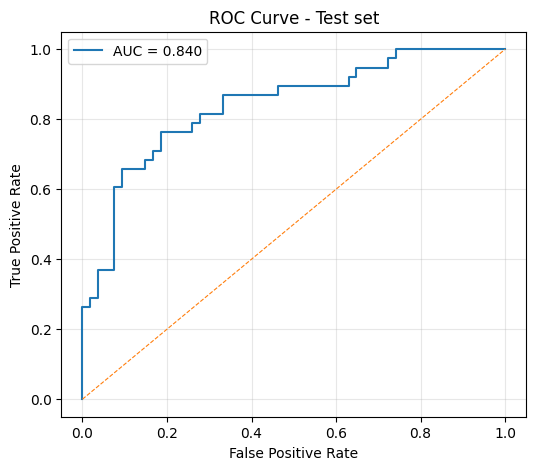

In [778]:
# XGB PARAMS
objective="multi:softprob"
eval_metric="mlogloss"

n_estimators = 300
n_estimators = 200

max_depth=3
# max_depth=6

learning_rate=0.05
learning_rate=0.01
# learning_rate=0.005

subsample=0.2
# subsample=0.5

colsample_bytree=1.0
colsample_bytree=0.6

max_features = 6
max_features = 9

n_jobs=-1

reg_alpha = 0.5   # L1 regularization
reg_alpha = 1.0   # L1 regularization

reg_lambda = 1.0  # L2 regularization

# pos_weight = len(nst_mdf[nst_mdf[tar_col]==1])/len(nst_mdf[nst_mdf[tar_col]==0])
pos_weight = 20000

min_child_weight = 20
    
objective="binary:logistic"
eval_metric="logloss"
params = {
        'objective' : objective,
        'eval_metric' : eval_metric,
        # 'scale_pos_weight' : pos_weight,
        'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        # 'min_child_weight' : min_child_weight,
        'learning_rate' : learning_rate,
        'subsample' : subsample,
        'colsample_bytree' : colsample_bytree,
        'max_features' : max_features,
        'random_state' : random_state,
        'n_jobs' : -1
}

print ('=== XGB PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=st_mdf,
    tar_col="payment",
    mcols=st_mcols,
    scale=scale,
    xgb=True,
    params=params
)

In [779]:
print ('CV Scores :', results['cv_scores'])
results["cv_summary"]

CV Scores : [0.78571429 0.73963134 0.76589147 0.71937984 0.82945736]


,roc_auc
mean,0.77
std,0.04


In [780]:
results["train_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.82,0.88,0.64,0.75,0.90


In [781]:
results["test_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.80,0.83,0.66,0.74,0.84


In [782]:
results["feature_importance"]

,feature,gain,orig_col
17,was_email_used,0.07,was_email_used
4,no_balance_reduction_flag,0.06,no_balance_reduction_flag
18,days_bw_last_notice_last_pmt,0.06,days_bw_last_notice_last_pmt
20,days_since_last_sms_delivered,0.06,days_since_last_sms_delivered
3,communication_vintage,0.06,communication_vintage
12,days_bw_chargeoff_last_pmt,0.06,days_bw_chargeoff_last_pmt
7,last_payment_to_balance,0.06,last_payment_to_balance
14,principal_reduction,0.06,principal_reduction
1,days_since_chargeoff,0.05,days_since_chargeoff
21,was_sms_used,0.05,was_sms_used


=== HGBM PARAMS ===
{'max_iter': 50, 'max_depth': 3, 'learning_rate': 0.01, 'min_samples_leaf': 10, 'l2_regularization': 0.2, 'random_state': 42}
Model used : HGBGM


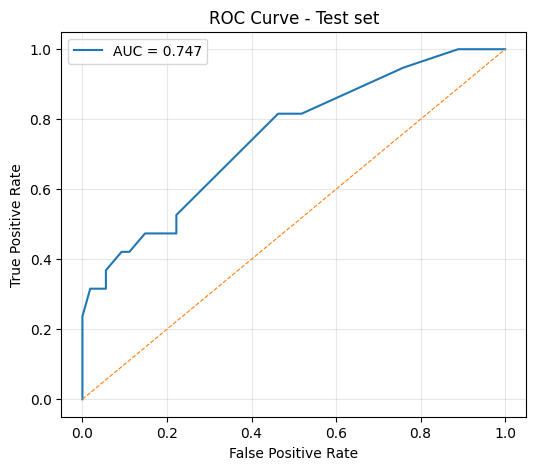

In [783]:
# HGBM
max_iter=50
max_depth=3
learning_rate=0.01
min_samples_leaf=10
l2=0.2
# monotonic_cst=monotonic_cst(OWNER_FEATURES)

params = {
    'max_iter' : max_iter,
    'max_depth' : max_depth,
    'learning_rate' : learning_rate,
    'min_samples_leaf' : min_samples_leaf,
    'l2_regularization' : l2,
    'random_state' : random_state
}
print ('=== HGBM PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=st_mdf,
    tar_col="payment",
    mcols=st_mcols,
    scale=scale,
    hgbm=True,
    params=params
)

In [784]:
print ('CV Scores :', results['cv_scores'])
results["cv_summary"]

CV Scores : [0.7703533  0.77918587 0.75465116 0.78217054 0.86550388]


,roc_auc
mean,0.79
std,0.04


In [785]:
results["train_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.72,0.81,0.41,0.55,0.84


In [786]:
results["test_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.68,0.80,0.32,0.45,0.75


In [787]:
results["feature_importance"]

,feature,importance_mean,importance_std
18,days_bw_last_notice_last_pmt,0.21,0.07
7,last_payment_to_balance,0.02,0.02
4,no_balance_reduction_flag,0.02,0.00
14,principal_reduction,0.02,0.01
0,principal_reduction_ratio,0.01,0.00
15,balance_ratio,0.00,0.00
13,drop_rate,0.00,0.00
5,days_since_last_contact,0.00,0.00
2,email_sent_delivered_ratio,0.00,0.00
1,days_since_chargeoff,0.00,0.00


#### Final model

=== XGB PARAMS ===
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.01, 'subsample': 0.2, 'colsample_bytree': 0.4, 'max_features': 9, 'random_state': 42, 'n_jobs': -1}
Model used : XGB


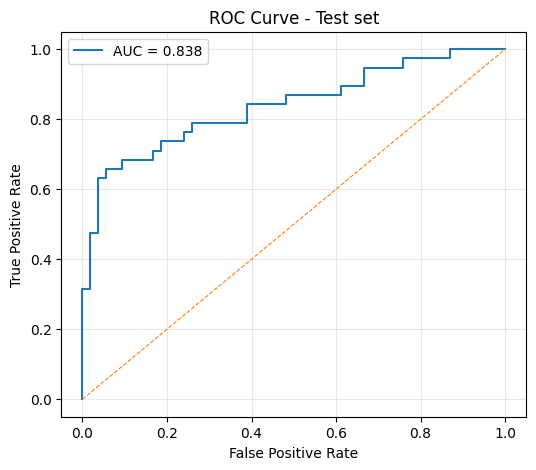

In [373]:
# XGB PARAMS
objective="multi:softprob"
eval_metric="mlogloss"

n_estimators = 300
# n_estimators = 400
# n_estimators = 200

# max_depth=3
max_depth=2

learning_rate=0.05
learning_rate=0.01
# learning_rate=0.005

subsample=0.2
# subsample=0.5

colsample_bytree=0.4
# colsample_bytree=0.6

# max_features = 11
max_features = 9

n_jobs=-1

reg_alpha = 0.5   # L1 regularization
reg_alpha = 1.0   # L1 regularization

reg_lambda = 1.0  # L2 regularization

# pos_weight = len(nst_mdf[nst_mdf[tar_col]==1])/len(nst_mdf[nst_mdf[tar_col]==0])
pos_weight = 20000

min_child_weight = 20
    
objective="binary:logistic"
eval_metric="logloss"
params = {
        'objective' : objective,
        'eval_metric' : eval_metric,
        # 'scale_pos_weight' : pos_weight,
        'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        # 'min_child_weight' : min_child_weight,
        'learning_rate' : learning_rate,
        'subsample' : subsample,
        'colsample_bytree' : colsample_bytree,
        'max_features' : max_features,
        'random_state' : random_state,
        'n_jobs' : -1
}

print ('=== XGB PARAMS ===')
print (params)

results = run_binary_model_pipeline(
    df=st_mdf,
    tar_col="payment",
    mcols=st_mcols,
    scale=scale,
    xgb=True,
    params=params
)

model = results['model']
y_train = results['y_train']
y_test = results['y_test']
y_proba_train = results['y_train_proba']
y_proba_test = results['y_test_proba']
X_train_processed = results['X_train_processed']
X_test_processed = results['X_test_processed']
feat_df = results["feature_importance"]

In [374]:
print ('CV Scores :', results['cv_scores'])
results["cv_summary"]

CV Scores : [0.74884793 0.70737327 0.73565891 0.70542636 0.8627907 ]


,roc_auc
mean,0.75
std,0.06


In [375]:
results["train_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.76,0.81,0.56,0.66,0.85


In [376]:
results["test_metrics"]

,accuracy,precision,recall,f1,roc_auc
0,0.82,0.89,0.63,0.74,0.84


In [377]:
feat_df

,feature,gain,orig_col
4,no_balance_reduction_flag,0.07,no_balance_reduction_flag
18,days_bw_last_notice_last_pmt,0.07,days_bw_last_notice_last_pmt
1,days_since_chargeoff,0.06,days_since_chargeoff
12,days_bw_chargeoff_last_pmt,0.06,days_bw_chargeoff_last_pmt
17,was_email_used,0.06,was_email_used
14,principal_reduction,0.06,principal_reduction
7,last_payment_to_balance,0.06,last_payment_to_balance
0,principal_reduction_ratio,0.06,principal_reduction_ratio
9,sms_sent_delivered_ratio,0.05,sms_sent_delivered_ratio
3,communication_vintage,0.05,communication_vintage


In [378]:
add_sc = 0
# add_sc = 500
# add_sc = -50

scale = 100
scale = 1000

y_train_scored = y_train.reset_index()
y_train_scored['prob'] = y_proba_train
y_train_scored['mscore'] = (y_train_scored['prob'])*scale

y_train_scored['mscore'] = y_train_scored['mscore'] + add_sc

y_train_scored['mscore'] = y_train_scored['mscore'].apply(lambda x : min(max(0, x), scale))

y_test_scored = y_test.reset_index()
y_test_scored['prob'] = y_proba_test
# y_test_scored['mscore'] = (1-y_test_scored['prob'])*1000.0
y_test_scored['mscore'] = (y_test_scored['prob'])*scale

y_test_scored['mscore'] = y_test_scored['mscore'] + add_sc

y_test_scored['mscore'] = y_test_scored['mscore'].apply(lambda x : min(max(0, x), scale))

y_scored = pd.concat([y_train_scored, y_test_scored], ignore_index=True)
y_scored.shape

(457, 4)

#### Final Testing Metrics 

In [379]:
cat_col = 'mscore'
df31 = y_test_scored.copy()

bins = [0.0, 99.0, 199.0, 299.0, 399.0, 499.0, 599.0, 699.0, 799.0, 899.0, 1000.0]
labels = ['0-99','100-199','200-299','300-399','400-499','500-599','600-699','700-799','800-899','900-1000']

df31[cat_col+'_cat'] = pd.cut(df31[cat_col].replace({'-':np.nan,'':np.nan}), bins=bins, labels=labels, include_lowest=True)
cat_col2 = cat_col+'_cat'

agg = df31[[cat_col2,tar_col]].value_counts(dropna=False).reset_index()

agg[cat_col2] = pd.Categorical(agg[cat_col2], categories=labels, ordered=True)
agg[cat_col2] = agg[cat_col2].astype(str)
agg['count%'] = round((agg['count']/agg['count'].sum())*100.0, 2)

agg = agg.pivot(index=[cat_col2], columns=[tar_col], values=['count']).reset_index()
agg.fillna(0,inplace=True)
agg.columns = [c[0] if c[1]=='' else str(c[0])+'_'+str(c[1]) for c in agg.columns]

agg.sort_values(cat_col2,inplace=True)

agg['total'] = agg['count_0']+agg['count_1']
agg['pay_rate'] = (agg['count_1']/(agg['count_0']+agg['count_1']))*100.0

agg['cumm_pay'] = agg['count_1'].cumsum()
agg['cumm_not_pay'] = agg['count_0'].cumsum()
agg['cumm_total'] = agg['cumm_pay'] + agg['cumm_not_pay']
agg['cumm_pay%'] = (agg['cumm_pay']/agg['count_1'].sum())*100.0
agg['cumm_not_pay%'] = (agg['cumm_not_pay']/agg['count_0'].sum())*100.0
agg['cumm_total%'] = (agg['cumm_total']/agg['total'].sum())*100.0
agg['KS'] = abs(agg['cumm_pay%']-agg['cumm_not_pay%'])

print ('==================TEST===================')
agg

==================TEST===================


,mscore_cat,count_0,count_1,total,pay_rate,cumm_pay,cumm_not_pay,cumm_total,cumm_pay%,cumm_not_pay%,cumm_total%,KS
0,100-199,5.00,0.00,5.00,0.00,0.00,5.00,5.00,0.00,9.26,5.43,9.26
1,200-299,11.00,2.00,13.00,15.38,2.00,16.00,18.00,5.26,29.63,19.57,24.37
2,300-399,17.00,5.00,22.00,22.73,7.00,33.00,40.00,18.42,61.11,43.48,42.69
3,400-499,18.00,7.00,25.00,28.00,14.00,51.00,65.00,36.84,94.44,70.65,57.60
4,500-599,3.00,13.00,16.00,81.25,27.00,54.00,81.00,71.05,100.00,88.04,28.95
5,600-699,0.00,6.00,6.00,100.00,33.00,54.00,87.00,86.84,100.00,94.57,13.16
6,700-799,0.00,5.00,5.00,100.00,38.00,54.00,92.00,100.00,100.00,100.00,0.00


In [380]:
cat_col = 'mscore'
df31 = y_scored.copy()

bins = [0.0, 99.0, 199.0, 299.0, 399.0, 499.0, 599.0, 699.0, 799.0, 899.0, 1000.0]
labels = ['0-99','100-199','200-299','300-399','400-499','500-599','600-699','700-799','800-899','900-1000']

df31[cat_col+'_cat'] = pd.cut(df31[cat_col].replace({'-':np.nan,'':np.nan}), bins=bins, labels=labels, include_lowest=True)
cat_col2 = cat_col+'_cat'

agg = df31[[cat_col2,tar_col]].value_counts(dropna=False).reset_index()

agg[cat_col2] = pd.Categorical(agg[cat_col2], categories=labels, ordered=True)
agg[cat_col2] = agg[cat_col2].astype(str)
agg['count%'] = round((agg['count']/agg['count'].sum())*100.0, 2)

agg = agg.pivot(index=[cat_col2], columns=[tar_col], values=['count']).reset_index()
agg.fillna(0,inplace=True)
agg.columns = [c[0] if c[1]=='' else str(c[0])+'_'+str(c[1]) for c in agg.columns]

agg.sort_values(cat_col2,inplace=True)

agg['total'] = agg['count_0']+agg['count_1']
agg['pay_rate'] = (agg['count_1']/(agg['count_0']+agg['count_1']))*100.0

agg['cumm_pay'] = agg['count_1'].cumsum()
agg['cumm_not_pay'] = agg['count_0'].cumsum()
agg['cumm_total'] = agg['cumm_pay'] + agg['cumm_not_pay']
agg['cumm_pay%'] = (agg['cumm_pay']/agg['count_1'].sum())*100.0
agg['cumm_not_pay%'] = (agg['cumm_not_pay']/agg['count_0'].sum())*100.0
agg['cumm_total%'] = (agg['cumm_total']/agg['total'].sum())*100.0
agg['KS'] = abs(agg['cumm_pay%']-agg['cumm_not_pay%'])

print ('==================OVERALL===================')
agg

==================OVERALL===================


,mscore_cat,count_0,count_1,total,pay_rate,cumm_pay,cumm_not_pay,cumm_total,cumm_pay%,cumm_not_pay%,cumm_total%,KS
0,100-199,18.00,0.00,18.00,0.00,0.00,18.00,18.00,0.00,6.74,3.94,6.74
1,200-299,83.00,7.00,90.00,7.78,7.00,101.00,108.00,3.68,37.83,23.63,34.14
2,300-399,73.00,25.00,98.00,25.51,32.00,174.00,206.00,16.84,65.17,45.08,48.33
3,400-499,68.00,47.00,115.00,40.87,79.00,242.00,321.00,41.58,90.64,70.24,49.06
4,500-599,24.00,56.00,80.00,70.00,135.00,266.00,401.00,71.05,99.63,87.75,28.57
5,600-699,1.00,41.00,42.00,97.62,176.00,267.00,443.00,92.63,100.00,96.94,7.37
6,700-799,0.00,14.00,14.00,100.00,190.00,267.00,457.00,100.00,100.00,100.00,0.00


In [381]:
st_mdf2 = st_mdf.reset_index()
print (len(set(st_mdf2[unq_id]).intersection(y_scored[unq_id])), st_mdf2[unq_id].nunique())

print (st_mdf2.shape)
st_mdf2 = pd.merge(st_mdf2, y_scored[[unq_id,'prob','mscore']], on=unq_id, how='left')
print (st_mdf2.shape)

457 457
(457, 27)
(457, 29)


KS Statistic: 0.5295
P-value: 0.0000


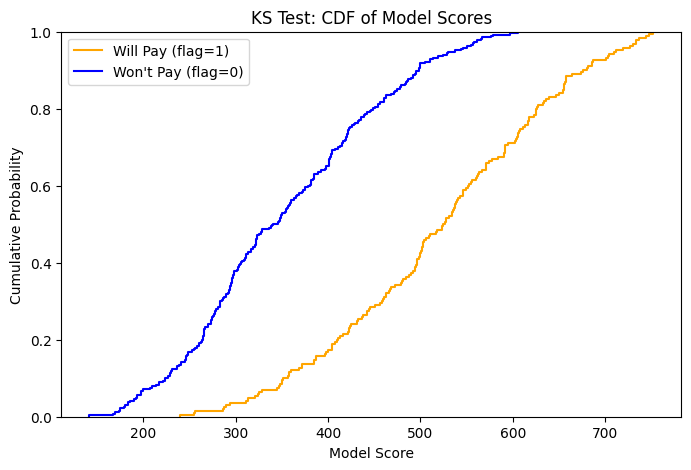

In [382]:
get_ks_value(st_mdf2,score='mscore',flag=tar_col)